In [454]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# user defined modules
import calculate#, plot
from calculate import gini, hhi, percentage_zeros, gini_nonzero
from credible_authors_ import DataStore

import warnings
warnings.filterwarnings("ignore")

# Configuration - needed?
gini_nonzero.display_name = 'Gini without zeroes'
percentage_zeros.display_name = 'Percentage of zeroes'
np.mean.display_name = 'Average'

START_YEAR = 1970
LAST_START_YEAR = 2000

In [2]:
# from importlib import reload
# reload(calculate)
# reload(plot)

In [3]:
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']

## Load data from csv

In [4]:
data_store = DataStore()
all_papers_num_cit = data_store.all_papers_num_cit

load publication data from CSV
load citation data from CSV
cited_papers_network - create
cited_papers_network - add start year
early_career_publications - create
all_papers_num_cit - create


In [5]:
author_order = pd.read_csv('derived-data/publication_authors_order_2017.csv')

In [418]:
credible_authors = pd.read_csv('derived-data/authors-scientific-extended.csv')

In [419]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'gender', 'early_career_qual_3', 'early_career_qual_first_3',
       'early_career_recognition_EC3_RC3', 'citation_count_3',
       'citation_count_10', 'citation_count_15', 'h-index_3', 'h-index_10',
       'h-index_15', 'early_career_coauthor_max_hindex_3',
       'citation_increase_10_3', 'h_index_increase_10_3',
       'citation_increase_15_3', 'h_index_increase_15_3', 'team_size_median_3',
       'team_size_mean_3', 'early_career_degree_3', 'early_career_prod_3',
       'h5_index_max_3', 'deciles_min_3', 'quantiles_min_3', 'quantiles_bin_3',
       'ec_first_auth_3', 'max_absence_0_15', 'avg_absence_0_15',
       'dropped_after_5', 'dropped_after_10'],
      dtype='object')

### Window counts

Load in citation window data:

In [428]:
WINDOW_SIZE = 3
citations_window = pd.read_csv(f'derived-data/citations_window_{WINDOW_SIZE}.csv')
citations_window_first = pd.read_csv(f'derived-data/citations_window_{WINDOW_SIZE}_first.csv')

In [429]:
# WINDOW_SIZE = 5
# citations_window_5 = pd.read_csv(f'derived-data/citations_window_{WINDOW_SIZE}.csv')
# citations_window_first_5 = pd.read_csv(f'derived-data/citations_window_{WINDOW_SIZE}_first.csv')

In [430]:
dropout_cols = ['author', 'dropped_after_10', 'dropped_after_5']
citations_window = citations_window.merge(credible_authors[dropout_cols], on='author', how='left')
citations_window_first = citations_window_first.merge(credible_authors[dropout_cols], on='author', how='left')

# citations_window_5 = citations_window_5.merge(credible_authors[dropout_cols], on='author', how='left')
# citations_window_first_5 = citations_window_first_5.merge(credible_authors[dropout_cols], on='author', how='left')

### Citations and uncited papers
Dataset with all the citations to papers, together with papers that received no citations (cit_id is null)

In [11]:
uncited_papers_network = data_store.authorPublicationData.merge(data_store.authorCitationsData, left_on='pub_id',
                                                                     right_on='id2', how='left',
                                                                     suffixes=('_pub', '_cit'))

In [12]:
# by merging here on 'inner', we remove duplicates with many authors
uncited_papers_network_first_auth = uncited_papers_network.merge(author_order[['first_author', 'pub_id']], 
                                                                 left_on=['author', 'pub_id'], 
                                                                 right_on=['first_author', 'pub_id'],how='inner')

In [13]:
# add start year
uncited_papers_network_first_auth = uncited_papers_network_first_auth.merge(data_store.credible_authors[
    ['author', 'start_year']], on='author', how='left')

In [14]:
uncited_papers_network_first_auth.drop('id2', axis='columns', inplace=True)
uncited_papers_network_first_auth.rename({'id1':'cit_id'}, axis='columns', inplace=True)

In [15]:
career_len = data_store.credible_authors[['author', 'career_length']]
# career_len_10 = career_len[career_len['career_length'] >= 10]

### UnCited papers network - first author

In [16]:
# uncited_papers_network_first_auth
# author == first_author
# contains all papers, with their first authors. 
# duplicate rows for pub_id are different citations, with cit_id for the citing paper
# cit_id == NaN -> paper never cited
uncited_papers_network_first_auth.head()

,author,year_pub,pub_id,cit_id,year_cit,first_author,start_year
0,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,NaN,NaN,gareth beale,2009
1,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,49ec0c15-7a9d-4378-a26a-f5063567b519,2013.0,altaf hossain,2006
2,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,ae0b4e3d-305d-4fb8-9847-60dcc9a9ec44,2014.0,altaf hossain,2006
3,jea-bum park,2011,00338203-9eb3-40c5-9f31-cbac73a519ec,NaN,NaN,jea-bum park,2011
4,giovanna guerrini,1998,0040b022-1472-4f70-a753-74832df65266,NaN,NaN,giovanna guerrini,1993


In [17]:
# aggregate citations, and get the count - per author, per year pub, per paper, per year cited
auth_year_pub_cit_count = uncited_papers_network_first_auth.groupby(
    ['author', 'year_pub', 'pub_id', 'year_cit']).agg({'cit_id': 'count'})
auth_year_pub_cit_count = auth_year_pub_cit_count.reset_index()

In [18]:
# add start year
auth_year_pub_cit_count = auth_year_pub_cit_count.merge(data_store.credible_authors[['author', 'start_year']], 
                                                        on='author', how='left')

In [19]:
# remove cited before published. Could be right, but makes the graphs weird
auth_year_pub_cit_count = auth_year_pub_cit_count[auth_year_pub_cit_count.year_cit >= auth_year_pub_cit_count.year_pub]

In [20]:
# take the best paper in a specific year cited
agg_cit_per_auth_year = auth_year_pub_cit_count.groupby(['start_year', 'author', 'year_pub', 'year_cit']).agg(
    {'cit_id': 'max'}).reset_index()

In [21]:
# take the average in a specific year cited
agg_cit_per_auth_year_avg = auth_year_pub_cit_count.groupby(['start_year', 'author', 'year_pub', 'year_cit']).agg(
    {'cit_id': 'mean'}).reset_index()

In [22]:
# veryfied this df for correctness with a different calc method
cohort_size_first_auth = uncited_papers_network_first_auth.groupby('start_year')['author'].nunique()
cohort_size_first_auth = cohort_size_first_auth.reset_index()
cohort_size_first_auth.rename({'author':'cohort_size'}, axis=1, inplace=True)

In [23]:
# add start year
agg_cit_per_auth_year = agg_cit_per_auth_year.merge(cohort_size_first_auth, on='start_year', how='left')
agg_cit_per_auth_year_avg = agg_cit_per_auth_year_avg.merge(cohort_size_first_auth, on='start_year', how='left')

In [24]:
agg_cit_per_auth_year = agg_cit_per_auth_year[(agg_cit_per_auth_year.start_year >= 1970) &
                                              (agg_cit_per_auth_year.start_year <=2000)]
agg_cit_per_auth_year_avg = agg_cit_per_auth_year_avg[(agg_cit_per_auth_year_avg.start_year >= 1970) &
                                              (agg_cit_per_auth_year_avg.start_year <=2000)]

#### Data interrogation 

In [25]:
uncited_papers_network_first_auth.dropna().cit_id.count()

8878763

In [26]:
uncited_papers_network_first_auth.year_pub.min()

1936

In [27]:
# author_order[author_order.pub_id == 'a43af2b6-93e5-480f-9678-8394483315a8']
uncited_papers_network_first_auth[uncited_papers_network_first_auth.pub_id == 'a43af2b6-93e5-480f-9678-8394483315a8']

,author,year_pub,pub_id,cit_id,year_cit,first_author,start_year
3041865,joseph mitola iii,1999,a43af2b6-93e5-480f-9678-8394483315a8,d6bb2dd1-cff1-4e4e-bf52-f8d470c4b05e,1999.0,joseph mitola iii,1999


In [28]:
uncited_papers_network_first_auth['pub_id'].nunique()

3059002

In [29]:
auth_year_pub_cit_count[(auth_year_pub_cit_count.start_year == 1999) & 
                        (auth_year_pub_cit_count.year_pub == 1999) &
#                         (auth_year_pub_cit_count.year_cit == 1999) &
                        (auth_year_pub_cit_count.author == 'joseph mitola iii')].sort_values('year_cit')

,author,year_pub,pub_id,year_cit,cit_id,start_year
1920699,joseph mitola iii,1999,a43af2b6-93e5-480f-9678-8394483315a8,1999.0,1,1999
1920691,joseph mitola iii,1999,2d6c7bfb-8ba1-4d19-a2f8-ec0ba40fa7d5,2002.0,1,1999
1920692,joseph mitola iii,1999,2d6c7bfb-8ba1-4d19-a2f8-ec0ba40fa7d5,2003.0,1,1999
1920700,joseph mitola iii,1999,f1e74152-3f7c-4c44-b628-cdf47a17587f,2005.0,1,1999
1920701,joseph mitola iii,1999,f1e74152-3f7c-4c44-b628-cdf47a17587f,2006.0,8,1999
1920693,joseph mitola iii,1999,2d6c7bfb-8ba1-4d19-a2f8-ec0ba40fa7d5,2007.0,1,1999
1920702,joseph mitola iii,1999,f1e74152-3f7c-4c44-b628-cdf47a17587f,2007.0,22,1999
1920703,joseph mitola iii,1999,f1e74152-3f7c-4c44-b628-cdf47a17587f,2008.0,47,1999
1920704,joseph mitola iii,1999,f1e74152-3f7c-4c44-b628-cdf47a17587f,2009.0,44,1999
1920694,joseph mitola iii,1999,2d6c7bfb-8ba1-4d19-a2f8-ec0ba40fa7d5,2010.0,2,1999


In [30]:
# these numbers are right, according to the combined df in 0.Data Preproc.
# this means i am grabbing all the citations by all the papers, and that the filters are fixed
agg_cit_per_auth_year[(agg_cit_per_auth_year.start_year == 1999) & 
                        (agg_cit_per_auth_year.year_pub == 1999) &
#                         (agg_cit_per_auth_year.year_cit == 1999) &
                        (agg_cit_per_auth_year.author == 'joseph mitola iii')].sort_values('year_cit')

,start_year,author,year_pub,year_cit,cit_id,cohort_size
1827686,1999,joseph mitola iii,1999,1999.0,1,17350
1827687,1999,joseph mitola iii,1999,2002.0,1,17350
1827688,1999,joseph mitola iii,1999,2003.0,1,17350
1827689,1999,joseph mitola iii,1999,2005.0,1,17350
1827690,1999,joseph mitola iii,1999,2006.0,8,17350
1827691,1999,joseph mitola iii,1999,2007.0,22,17350
1827692,1999,joseph mitola iii,1999,2008.0,47,17350
1827693,1999,joseph mitola iii,1999,2009.0,44,17350
1827694,1999,joseph mitola iii,1999,2010.0,121,17350
1827695,1999,joseph mitola iii,1999,2011.0,125,17350


In [31]:
# number of first authors in 1994
uncited_papers_network_first_auth[uncited_papers_network_first_auth.start_year == 1994]['author'].nunique()

11743

In [32]:
agg_cit_per_auth_year[(agg_cit_per_auth_year.start_year == 1994)]['author'].nunique()# & (agg_cit_per_auth_year.year_cit == 1994)]

8307

In [33]:
# i guess also all authors in 1994
auths_1994 = agg_cit_per_auth_year[(agg_cit_per_auth_year.start_year == 1994) & 
                      (agg_cit_per_auth_year.year_cit == 1994)]['author'].unique()
print(auths_1994.shape)

(319,)


In [34]:
author_order = author_order.merge(data_store.credible_authors[
    ['author', 'start_year']], left_on='first_author', right_on='author', how='left')

In [35]:
# all first authors in 1994
all_auths_1994 = author_order[author_order.start_year==1994]['author'].unique()
print(all_auths_1994.shape)

(11743,)


### top k percent 

In [36]:
agg_cit_per_auth_year['cit_id'] = agg_cit_per_auth_year['cit_id'].astype(int)

In [37]:
# TODO: Flaw: array is not full. Taking k percent of non zeros. Add the missing zeros
def perc_owned_by_top_k(arr, size, k):
    arr = arr.values
    top_k = int(round((size/100)*k))
    return sum(arr[arr.argsort()[-top_k:]])/sum(arr)

In [38]:
k=1
perc_owned = agg_cit_per_auth_year.groupby(['start_year', 'year_pub', 'year_cit'])['cit_id', 'cohort_size'].apply(
    lambda x: perc_owned_by_top_k(x['cit_id'], x['cohort_size'].max(), k)).reset_index()
perc_owned.rename({0: 'perc_owned'}, axis=1, inplace=True)

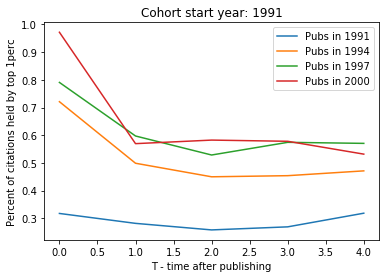

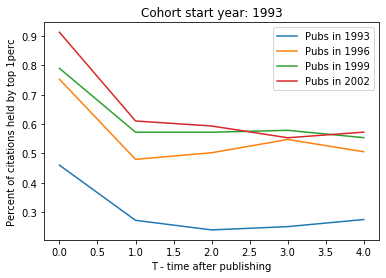

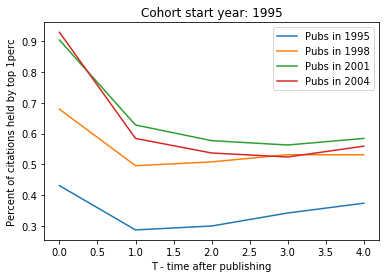

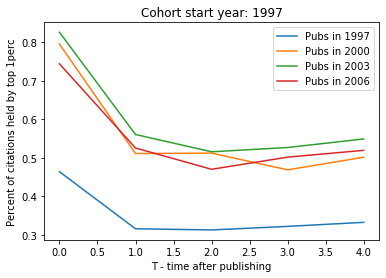

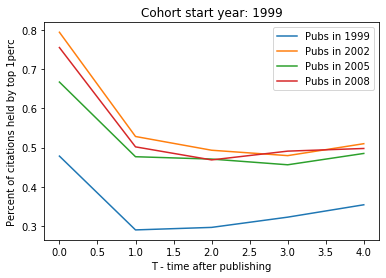

In [39]:
data = perc_owned
metric = 'perc_owned'
for start_year in data.start_year.unique()[-10::2]:
    cohort_data = data[data.start_year == start_year]
    for year_pub in cohort_data.year_pub.unique()[:11:3]:
        one_year = cohort_data[cohort_data.year_pub == year_pub]
        plt.plot(range(0,5), one_year[metric][:5], label=f'Pubs in {year_pub}')
    plt.ylabel(f'Percent of citations held by top {k}perc')
    plt.xlabel('T - time after publishing')
    plt.title(f'Cohort start year: {start_year}')
    plt.legend()
    plt.show()

## Gini across cohorts

In [510]:
def aggregate_cohort_data(citations_window, func):
    gini_cohorts_ca = citations_window.groupby(['start_year', 'career_age']).agg({
        'num_pub': func,
        'num_cit': func,
        'cum_num_pub': func,
        'cum_num_cit': func}).reset_index()
    return gini_cohorts_ca

In [511]:
gini_cohorts_ca = aggregate_cohort_data(citations_window, gini)
gini_cohorts_ca_first = aggregate_cohort_data(citations_window_first, gini)

In [538]:
def plot_criteria_over_cohorts(data, criteria, criteria_name, title, letter, legend=True, name_ext=''):
    linewidth = 2
    fontsize = 18
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    color = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
    career_ages = [10,5,2]
    for i in range(0, len(career_ages)):
        df = data[data['career_age'] == career_ages[i]]
        ax.plot(df['start_year'], df[criteria], linewidth=linewidth, label=career_ages[i], color=color[i])
#     ax.set_xlim([0.25, 15.75])
    if('cum' in criteria): ax.set_ylim([0.1, 1.05])
    else: ax.set_ylim([0.38, 1.05])
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_xlabel('Cohort start year', fontsize=fontsize)
    ax.set_ylabel(f'{criteria_name}', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xticks([1970, 1980, 1990, 2000])
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    if legend: ax.legend(fontsize=fontsize-6)
    plt.gcf().text(0., 0.9, letter, fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    fig.savefig(f'./fig-7-notebook/{criteria}_over_cohorts{name_ext}.pdf')

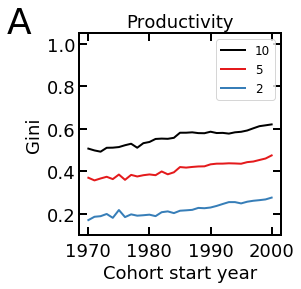

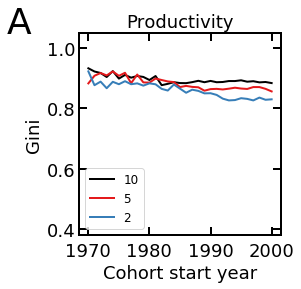

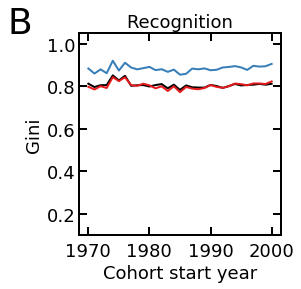

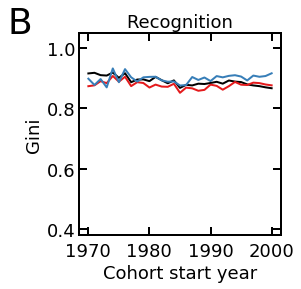

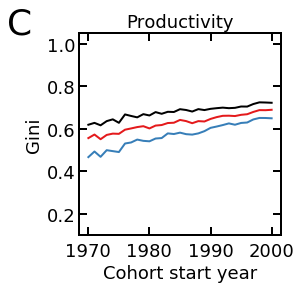

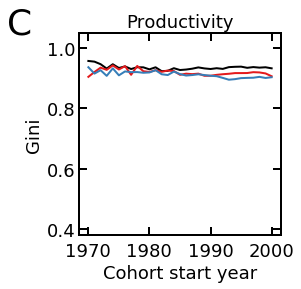

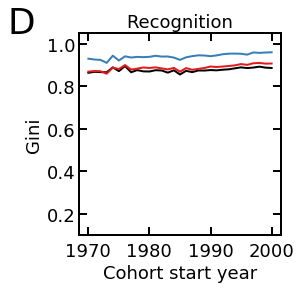

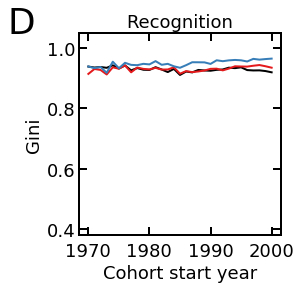

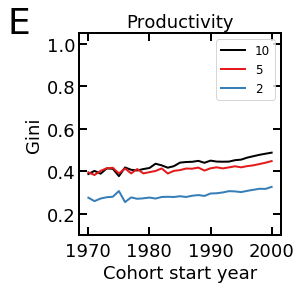

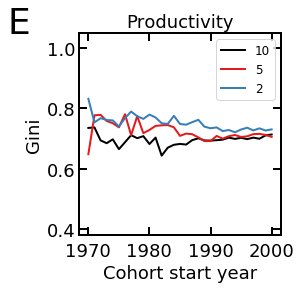

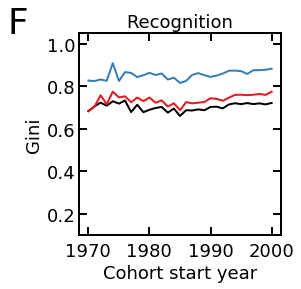

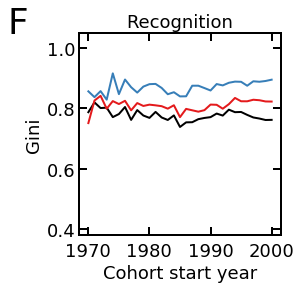

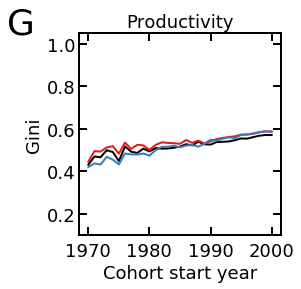

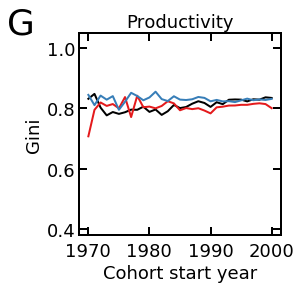

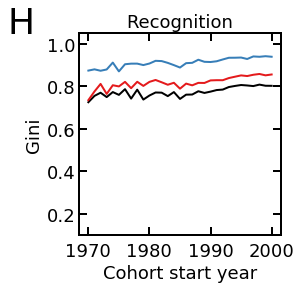

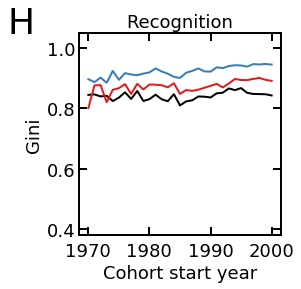

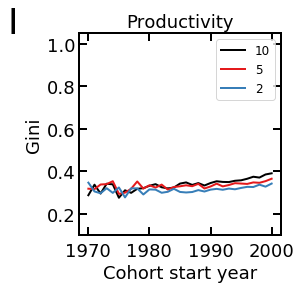

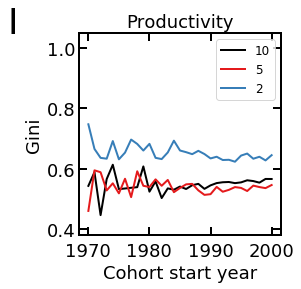

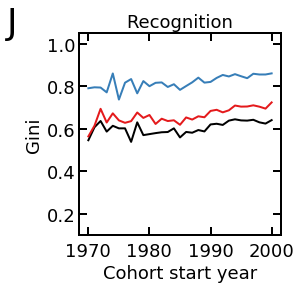

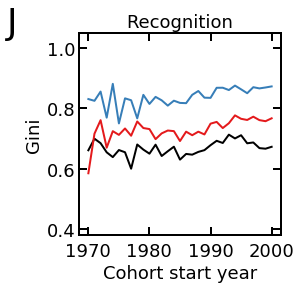

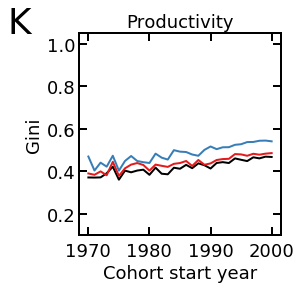

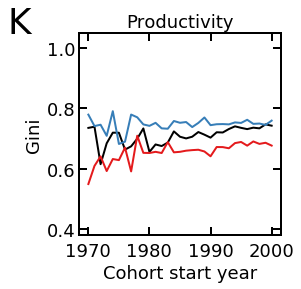

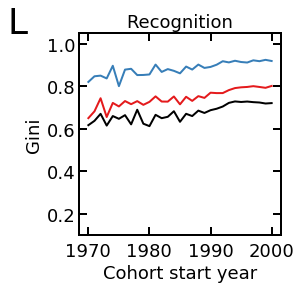

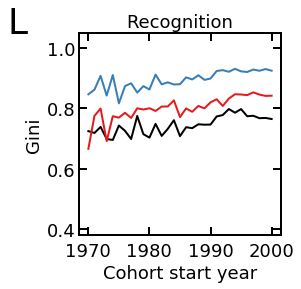

In [539]:
def plot_for_latex3(citations_window, citations_window_first):
    # all authors
    gini_cohorts_ca = aggregate_cohort_data(citations_window, gini)
    plot_array_configs2(gini_cohorts_ca, get_config2('gini', 'Gini'), letters11)
    # first author
    gini_cohorts_ca_first = aggregate_cohort_data(citations_window_first, gini)
    plot_array_configs2(gini_cohorts_ca_first, get_config2('gini', 'Gini'), letters12, name_ext='_first')
    # dropouts removed 10y
    citations_window_stayed = citations_window[citations_window.dropped_after_10 == False]
    gini_cohorts_ca_stayed = aggregate_cohort_data(citations_window_stayed, gini)
    plot_array_configs2(gini_cohorts_ca_stayed, get_config2('gini', 'Gini'), letters21, name_ext='_stay10')
    # dropouts removed first auth 10y
    citations_window_stayed_first = citations_window_first[citations_window_first.dropped_after_10 == False]
    gini_cohorts_ca_stayed_first = aggregate_cohort_data(citations_window_stayed_first, gini)
    plot_array_configs2(gini_cohorts_ca_stayed_first, get_config2('gini', 'Gini'), letters22, name_ext='_stay10_first')
    # dropouts removed 5y
    citations_window_stayed_5 = citations_window[citations_window.dropped_after_5 == False]
    gini_cohorts_ca_stayed_5 = aggregate_cohort_data(citations_window_stayed_5, gini)
    plot_array_configs2(gini_cohorts_ca_stayed_5, get_config2('gini', 'Gini'), letters31, name_ext='_stay5')
    # dropouts removed first auth 5y
    citations_window_stayed_first_5 = citations_window_first[citations_window_first.dropped_after_5 == False]
    gini_cohorts_ca_stayed_first_5 = aggregate_cohort_data(citations_window_stayed_first_5, gini)
    plot_array_configs2(gini_cohorts_ca_stayed_first_5, get_config2('gini', 'Gini'), letters32, name_ext='_stay5_first')
plot_for_latex3(citations_window, citations_window_first)

### gini

In [40]:
def gini_expand(arr, size):
#     print(len(arr), size)
    num_zer = size - len(arr)
    arr_full = np.append(arr, np.zeros(num_zer))
    return gini(arr_full)

In [41]:
def get_expanded_gini_df(data):
    df_gini = data.groupby(['start_year', 'year_pub', 'year_cit'])['cit_id', 'cohort_size'].apply(
        lambda x: gini_expand(x['cit_id'], x['cohort_size'].max())).reset_index()
    df_gini.rename({0: 'gini'}, axis=1, inplace=True)
    return df_gini

In [42]:
df_gini_max = get_expanded_gini_df(agg_cit_per_auth_year)
df_gini_avg = get_expanded_gini_df(agg_cit_per_auth_year_avg)

df_gini_max['career_age'] = df_gini_max['year_pub'] - df_gini_max['start_year'] + 1
df_gini_avg['career_age'] = df_gini_avg['year_pub'] - df_gini_avg['start_year'] + 1

The inequality is very big because of the granularity of this chart. 
We first divide people into cohorts. Then for different career agees, we divide the paper's citations across Time after publishing, T. This makes the data very sparse, and we end up with a huge number of zeroes. <br>
Example: <br>
Published in 1991, cited in 1992 and 1995 <br>
Array: [0, X, 0, 0, Y]

In [43]:
def plot_ineq_(data, metric, ext):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    i = 0
    flat_axes = list(axs.flat)
    for start_year in [1970, 1980, 1990, 2000]:
        ax = flat_axes[i]
        cohort_data = data[data.start_year == start_year]
        for year_pub in cohort_data.year_pub.unique()[:11:3]:
            one_year = cohort_data[cohort_data.year_pub == year_pub]
            ax.plot(range(0,5), one_year[metric][:5], label=f'Career age {year_pub-start_year+1}')
        ax.set_title(f'Cohort start year: {start_year}')
        ax.legend()
        i+=1
    for ax in axs.flat:
        ax.set(xlabel='T - time after publishing', ylabel='Gini over citations')
    fig.suptitle(f"Aggregation metric: {ext}")
    fig.savefig(f'./fig-7-notebook/first_auth_ineq_gini_{ext}.pdf')
    fig.show()
# plot_ineq_(df_gini_max, 'gini', 'max')
# plot_ineq_(df_gini_avg, 'gini', 'avg')

In [44]:
# 5 year df for max
df_gini_max_y5 = df_gini_max[df_gini_max.year_cit == df_gini_max.year_pub + 4]
career_ages = [1,2,4,7,10]
df_gini_max_y5 = df_gini_max_y5[df_gini_max_y5['career_age'].isin(career_ages)]

In [45]:
# 5 year df for max
df_gini_avg_y5 = df_gini_avg[df_gini_avg.year_cit == df_gini_avg.year_pub + 4]
career_ages = [1,2,4,7,10]
df_gini_avg_y5 = df_gini_avg_y5[df_gini_avg_y5['career_age'].isin(career_ages)]

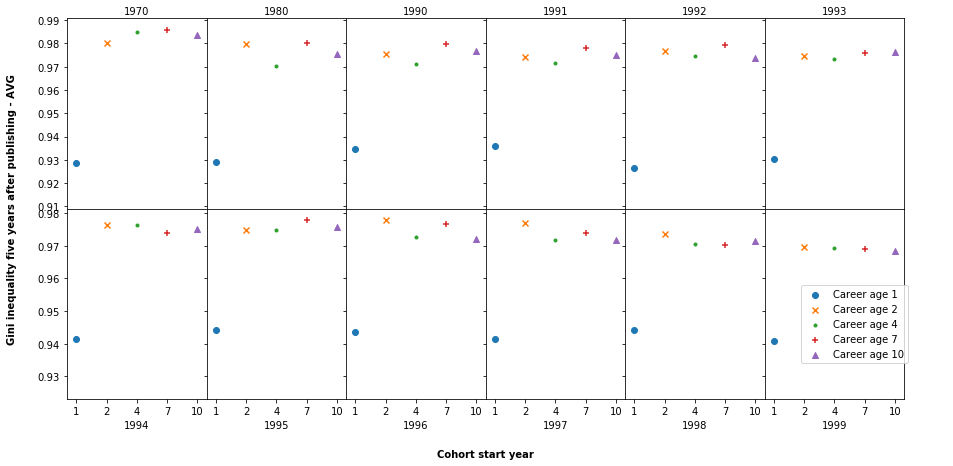

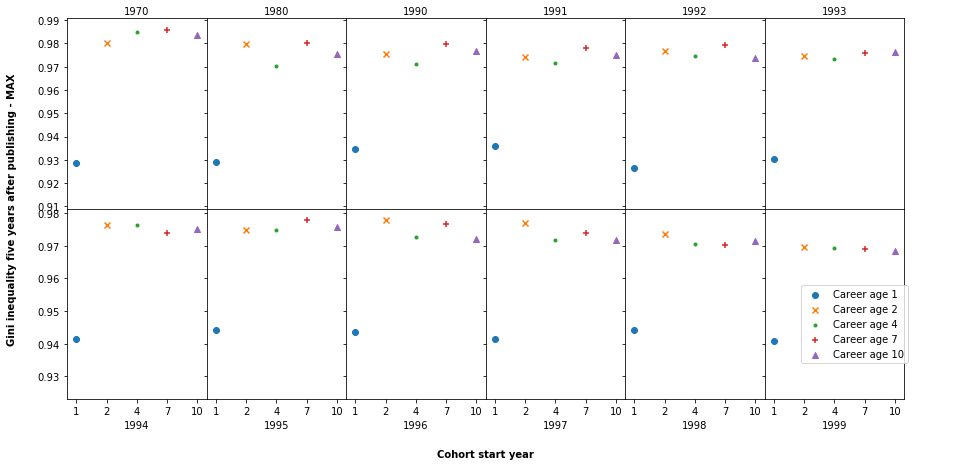

In [46]:
def plot_first_auth_ineq_gini(data_df, param):
    career_ages = [1,2,4,7,10]
    career_ages = [str(x) for x in career_ages]
    start_years_gini = [1970, 1980, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
    data = data_df[data_df.start_year.isin(start_years_gini)]

    fig, axs = plt.subplots(2, 6, sharex='col', sharey='row',
                            gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(15,7))

    ax_outside = fig.add_subplot(111, frameon=False)
    ax_outside.grid(False)
    ax_outside.axes.get_xaxis().set_ticks([])
    ax_outside.axes.get_yaxis().set_ticks([])

    markers = ['o', 'x', '.', '+', '^']

    for ax, year in zip(axs.flat, start_years_gini):
        x = list(range(5))
        y = data[data.start_year == year]['gini']
        for marker, x_pos, y_val in zip(markers, x, y):
            ax.scatter(x_pos, y_val, marker=marker, label=f'Career age {career_ages[x_pos]}')
        ax.set_xlabel(year)
        ax.set_xticks(x)

    for ax in axs.flat:
    #     ax.label_outer()
        ax.grid(False)
        ax.set_xticklabels(career_ages)
    for ax in axs.flat[:6]:
        ax.xaxis.set_label_position('top') 
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.84,0.22))

    ax_outside.set_xlabel('Cohort start year', labelpad=50, fontweight='bold')
    ax_outside.set_ylabel(f'Gini inequality five years after publishing - {param.upper()}', labelpad=50, fontweight='bold')
    fig.savefig(f'./fig-7-notebook/first_auth_ineq_gini_{param}_squeze.pdf')
plot_first_auth_ineq_gini(df_gini_max_y5, 'avg')
plot_first_auth_ineq_gini(df_gini_max_y5, 'max')

### Cliffs Delta

In [336]:
cum_cit_pub_agg_first = citations_window_first.groupby(['start_year', 'career_age', 'gender']).agg({
    'cum_num_pub': list,
    'cum_num_cit': list
}).reset_index()

cum_cit_pub_agg = citations_window.groupby(['start_year', 'career_age', 'gender']).agg({
    'cum_num_pub': list,
    'cum_num_cit': list
}).reset_index()

In [337]:
def get_cohort_effect_size(cohort_careerage_df, metric, gen_a='m', gen_b='f', eff_form='r'):
    data = cohort_careerage_df[cohort_careerage_df.gender.isin([gen_a, gen_b])]
    data = data.set_index(['start_year', 'career_age', 'gender']).unstack(level=-1)
    data.columns = ['_'.join(col) for col in data.columns]
    data['cliffd_m_f'] = data.apply(lambda x: calculate.cliffsD(x[f'{metric}_{gen_a}'], x[f'{metric}_{gen_b}']), axis=1)
    mwu = data.apply(lambda x: calculate.mann_whitney_effect_size(
        x[f'{metric}_{gen_a}'], x[f'{metric}_{gen_b}'], effect_formula=eff_form), axis=1).apply(pd.Series)
    mwu.columns = ['effect', 'statistic', 'pvalue']
    data = data.join(mwu)
    data = data[['cliffd_m_f', 'effect', 'statistic', 'pvalue']]
    data = data.reset_index()
    return data    

In [540]:
# TEST Debugger
from IPython.core.debugger import set_trace
def plot_cohort_diffs_over_ages(stats, criterion, criterion_display, ext='', remove_half=False):
    # x - career age
#     plt = plot.init_plotting()
    i = 0  # to point to the right figure
    j = 0

    # rearange subplots dynamically
    cols = 3
    fig_size = 7
    cohort_start_years = np.unique(stats["start_year"].values)
    # remove 1970 from plot
    cohort_start_years = cohort_start_years[1:]
    if remove_half:
        # remove every second year
        cohort_start_years = cohort_start_years[1::2]
    # 15 cohorts?
    num_coh = len(cohort_start_years)
    if (num_coh > 20):
        cols = 6
        fig_size = 14

    nrows = math.ceil(float(len(cohort_start_years)) / float(cols))
    nrows = int(nrows)

    fig3, ax3 = plt.subplots(nrows, cols, sharex=True, sharey=True, figsize=(fig_size, 10))  # sharey=True,
    # Create a big subplot to created axis labels that scale with figure size
    ax_outside = fig3.add_subplot(111, frameon=False)
    ax_outside.grid(False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax_outside.set_xlabel('Career Age', labelpad=20, fontweight='bold')
    ax_outside.set_ylabel(f'Cliffs Delta m-f {criterion_display}', labelpad=20, fontweight='bold')

    for year in cohort_start_years:
        cohort = stats[stats["start_year"] == year]
        
        sig_male = cohort[(cohort['cliffd_m_f']>=0.1)].shape[0]# & (cohort.pvalue <= 0.05)
        sig_female = cohort[(cohort['cliffd_m_f']<=-0.1)].shape[0]# & (cohort.pvalue <= 0.05)
        significant_effect = cohort[cohort.pvalue <= 0.05]
        
        sig_eff_career_ages = significant_effect.career_age.values
        sig_eff_career_ages = [index - 1 for index in sig_eff_career_ages]

        ax3[i, j].plot(cohort["career_age"], cohort["cliffd_m_f"].values, '-D', markevery=sig_eff_career_ages)
        ax3[i, j].set_title(f"{year}", fontsize=12, fontweight="bold")
        ax3[i, j].set_ylim([-0.05, 0.22])
        ax3[i, j].set_yticks([0.0, 0.1, 0.2])
        
                            #(M:{sig_male} F:{sig_female} S:{significant_effect.shape[0]})", 
        # ax3[i,j].grid(True)

        if (j < cols - 1):
            j = j + 1
        else:
            j = 0
            i = i + 1

    fig3.savefig(f"./fig-7-notebook/{criterion}{ext}_gender_{num_coh}.png", facecolor=fig3.get_facecolor(), edgecolor='none',
                 bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close(fig3)

#### What are the variance differences between the population of men and women

In [163]:
cum_cit_pub_agg_first_m_f = cum_cit_pub_agg_first[cum_cit_pub_agg_first.gender.isin(['m', 'f'])]
cum_cit_pub_agg_first_m_f['cum_num_pub_var'] = cum_cit_pub_agg_first_m_f['cum_num_pub'].apply(np.var)
cum_cit_pub_agg_first_m_f['cum_num_cit_var'] = cum_cit_pub_agg_first_m_f['cum_num_cit'].apply(np.var)

In [166]:
cum_cit_pub_agg_first_m_f.groupby(['start_year', 'career_age'])['cum_num_pub_var'].apply(pd.DataFrame.diff)

0            NaN
1       0.025160
3            NaN
4      -1.353784
6            NaN
          ...   
1387    7.505944
1389         NaN
1390    8.660736
1392         NaN
1393    9.716298
Name: cum_num_pub_var, Length: 930, dtype: float64

#### Plot

In [339]:
mwu_cliff_d_cum_pub_first = get_cohort_effect_size(cum_cit_pub_agg_first, 'cum_num_pub')
mwu_cliff_d_cum_cit_first = get_cohort_effect_size(cum_cit_pub_agg_first, 'cum_num_cit')

mwu_cliff_d_cum_pub = get_cohort_effect_size(cum_cit_pub_agg, 'cum_num_pub')
mwu_cliff_d_cum_cit = get_cohort_effect_size(cum_cit_pub_agg, 'cum_num_cit')

In [310]:
# TODO are mwu and delta same sided?

,start_year,career_age,cliffd_m_f,effect,statistic,pvalue
0,1970,1,0.096223,0.044541,7980.5,2.754760e-01
1,1970,2,0.104258,0.048261,8039.0,2.520783e-01
2,1970,3,0.057967,0.026833,7702.0,5.344045e-01
3,1970,4,0.071635,0.033159,7801.5,4.486408e-01
4,1970,5,0.042651,0.019743,7590.5,6.563712e-01
...,...,...,...,...,...,...
460,2000,11,0.043332,0.030446,39385528.0,2.877390e-06
461,2000,12,0.045768,0.032158,39477509.0,8.031306e-07
462,2000,13,0.047201,0.033164,39531577.5,3.748476e-07
463,2000,14,0.048375,0.033989,39575901.0,1.979245e-07


In [366]:
def get_effect_size_stats(stats):
    effect_size_count = stats.groupby('start_year').agg({'cliffd_m_f': [lambda x: sum(x >= 0.1), lambda x: sum(x <= -0.1)],
                                                         'pvalue': lambda x: sum(x <= 0.05)})
    effect_size_count.columns = ['sig_male', 'sig_female', 'sig_mwu']
    return effect_size_count
def get_num_larger_female(stats):
    stats = stats[~(stats.start_year == 1970)]
    num_fem_larger = stats.groupby('start_year').agg({'cliffd_m_f': lambda x: sum(x < 0) })
    return num_fem_larger

In [397]:
num_larg_female[num_larg_female.cliffd_m_f > 0].shape[0]

22

In [388]:
def report1(stats):
    num_larg_female = get_num_larger_female(stats)
#     print(num_larg_female)
    print(f"num observations {num_larg_female.sum().values[0]}")
    print(f"num cohorts with these observations {num_larg_female[num_larg_female.cliffd_m_f > 0].shape[0]}")
report1(mwu_cliff_d_cum_cit)
report1(mwu_cliff_d_cum_cit_first)
# report1(mwu_cliff_d_cum_pub)
# report1(mwu_cliff_d_cum_pub_first)

num observations 130.0
num cohorts with these observations 22
num observations 67.0
num cohorts with these observations 19


In [368]:
mwu_cliff_d_cum_cit[mwu_cliff_d_cum_cit.start_year == 1991]

,start_year,career_age,cliffd_m_f,effect,statistic,pvalue
315,1991,1,0.007095,0.004638,4627752.5,0.343846
316,1991,2,-0.017271,-0.011290,4515786.0,0.119314
317,1991,3,-0.039019,-0.025507,4415850.5,0.003520
318,1991,4,-0.042970,-0.028089,4397697.0,0.003379
319,1991,5,-0.030628,-0.020022,4454408.0,0.045246
320,1991,6,-0.026264,-0.017714,4470627.0,0.085027
321,1991,7,-0.018590,-0.013468,4500480.0,0.197126
322,1991,8,-0.018295,-0.012342,4508394.5,0.241729
323,1991,9,-0.010692,-0.007055,4545555.0,0.506700
324,1991,10,-0.008035,-0.006119,4552135.0,0.567358


In [347]:
dfs = [mwu_cliff_d_cum_pub, mwu_cliff_d_cum_cit, mwu_cliff_d_cum_pub_first, mwu_cliff_d_cum_cit_first]
names = ['Publications', 'Citations', 'Pub. first', 'Cit. first']
res = []
res2 = []
for df in dfs:
    effect_size_count = get_effect_size_stats(df)
    effect_size_count = effect_size_count.drop(1970)
    res.append(effect_size_count[effect_size_count >= 1.0].count())
    res2.append(effect_size_count.sum())
#     print(effect_size_count)
#     print()
num_cohorts = pd.DataFrame(res)
num_cohorts = num_cohorts.T
num_cohorts.columns = names

In [348]:
# number of cohorts with sig_male, sig_female or sig_mwu showing up at least once 
num_cohorts

,Publications,Citations,Pub. first,Cit. first
sig_male,6,2,5,3
sig_female,0,0,0,0
sig_mwu,22,11,14,13


In [349]:
num_observations = pd.DataFrame(res2)
num_observations = num_observations.T
num_observations.columns = names

In [360]:
# total num of significant observations
num_observations

,Publications,Citations,Pub. first,Cit. first
sig_male,52.0,13.0,29.0,25.0
sig_female,0.0,1.0,0.0,0.0
sig_mwu,254.0,87.0,131.0,109.0


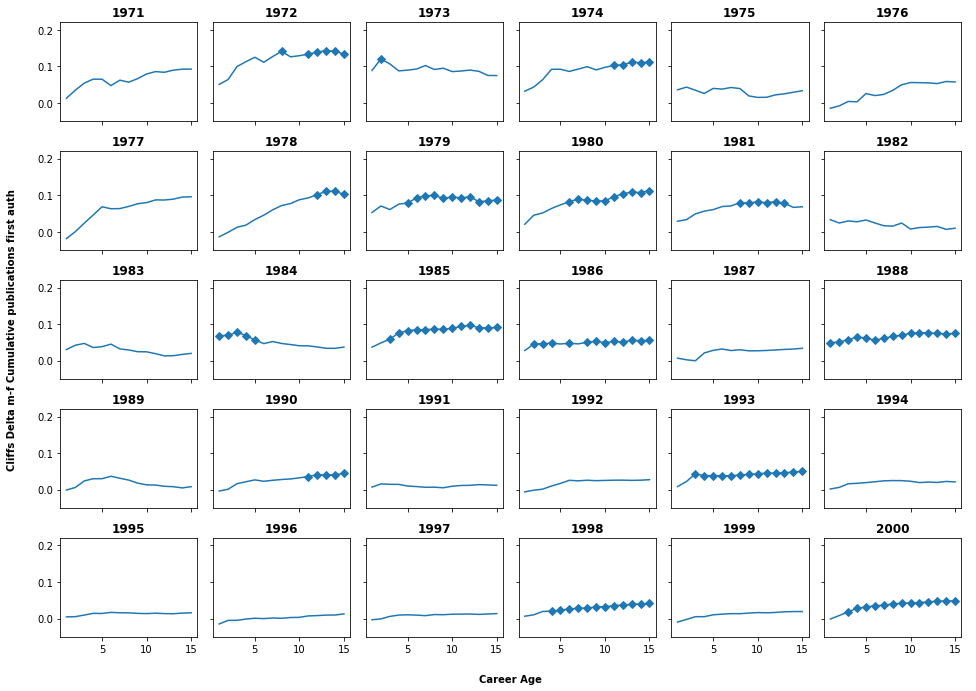

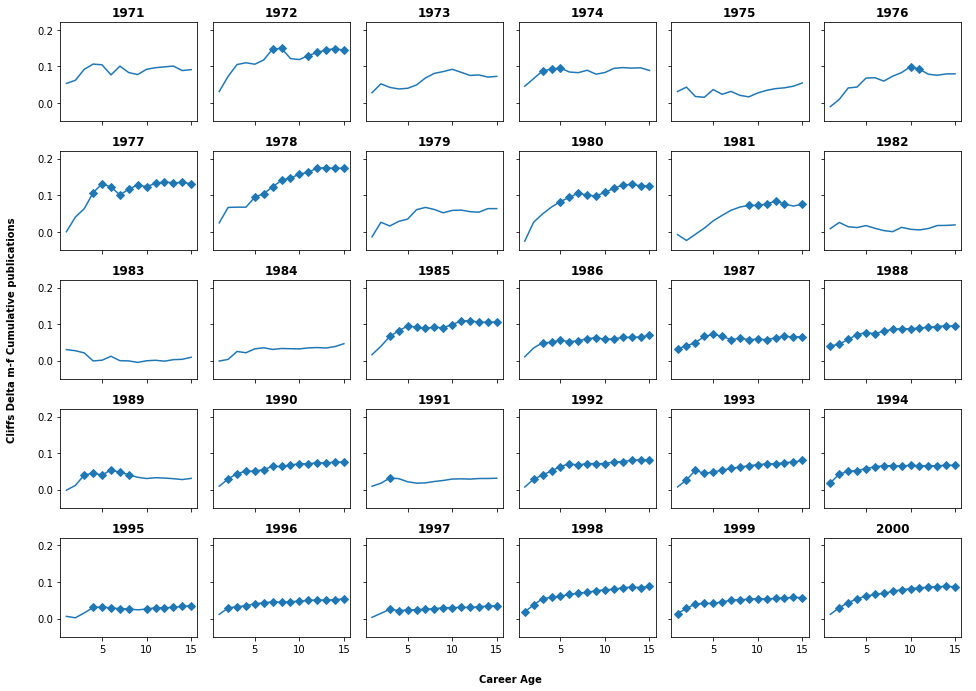

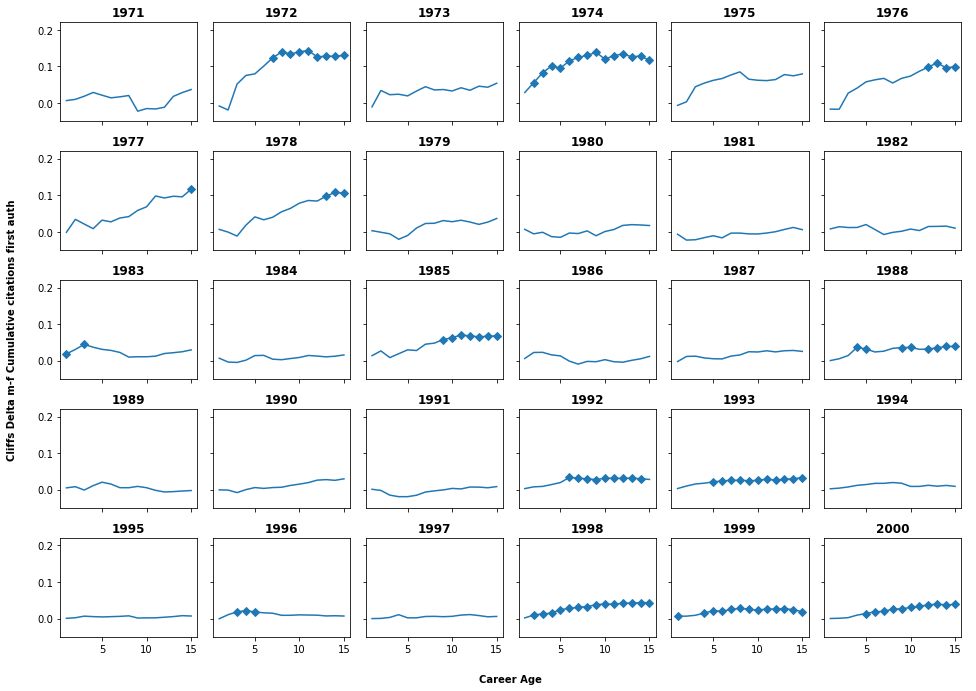

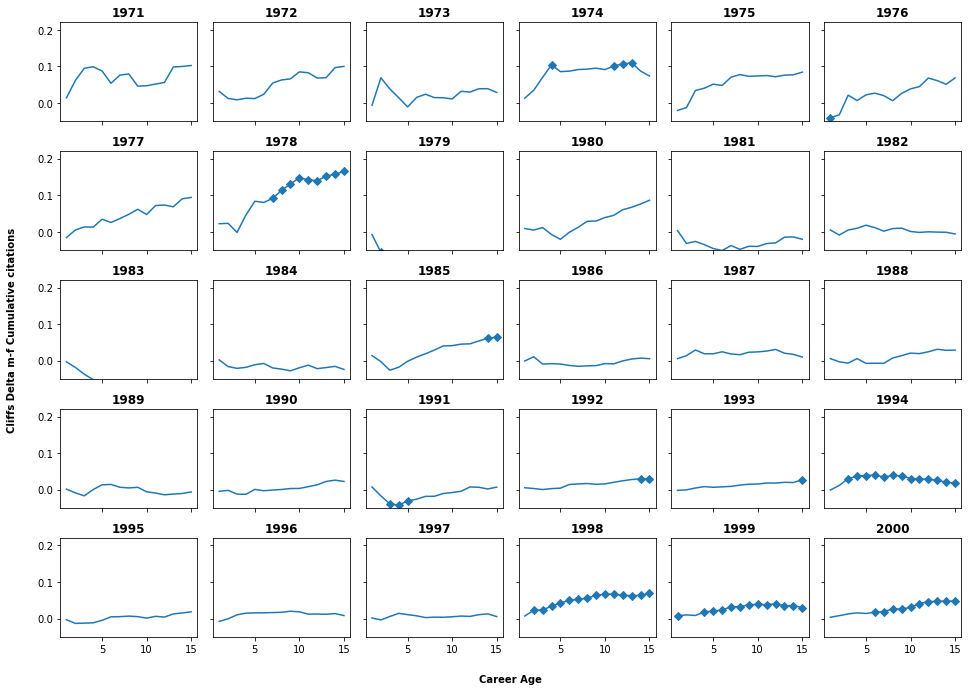

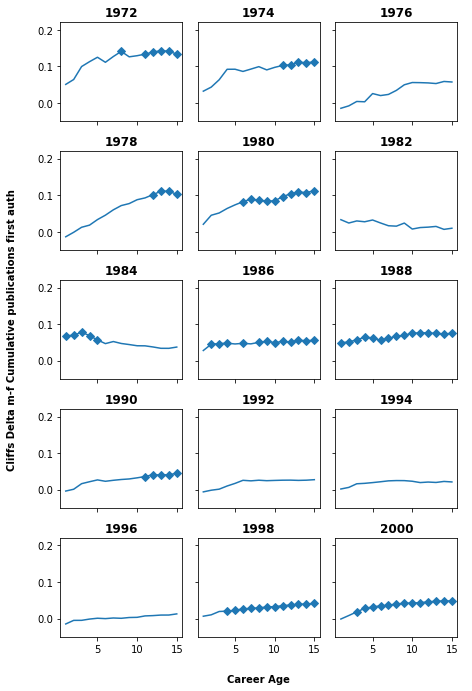

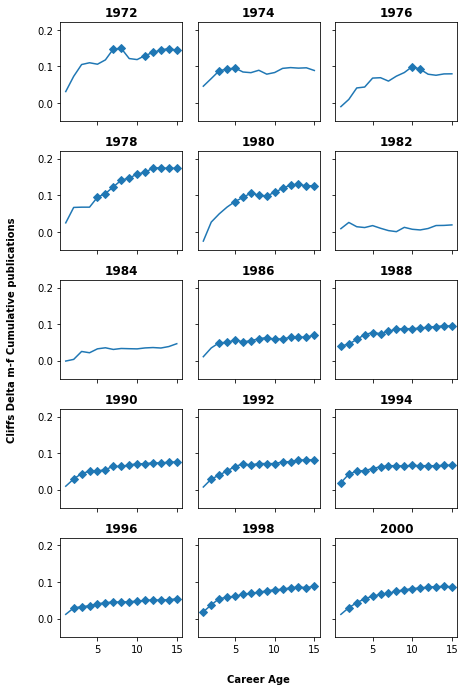

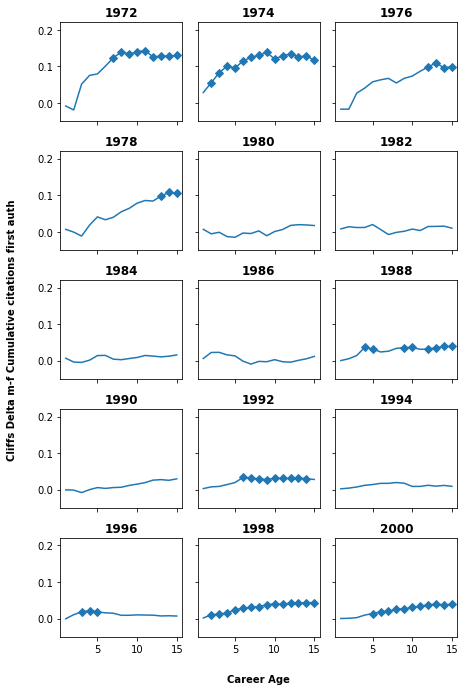

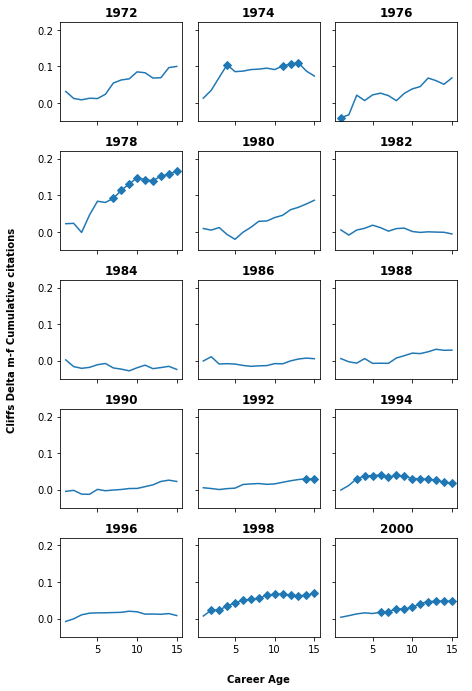

In [541]:
# pubs
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_pub_first, 'mwu_cliffsd_cum_pub', 'Cumulative publications first auth', ext='_first')
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_pub, 'mwu_cliffsd_cum_pub', 'Cumulative publications')

# cit
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_cit_first, 'mwu_cliffsd_cum_cit', 'Cumulative citations first auth', ext='_first')
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_cit, 'mwu_cliffsd_cum_cit', 'Cumulative citations')

# pubs
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_pub_first, 'mwu_cliffsd_cum_pub', 'Cumulative publications first auth',
                            ext='_first', remove_half=True)
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_pub, 'mwu_cliffsd_cum_pub', 'Cumulative publications', remove_half=True)

# cit
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_cit_first, 'mwu_cliffsd_cum_cit', 'Cumulative citations first auth', 
                            ext='_first', remove_half=True)
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_cit, 'mwu_cliffsd_cum_cit', 'Cumulative citations', remove_half=True)

## Inequality of papers

In [56]:
def plot_ineq_papers_cohort(cohort_year, years_in_future=5, career_ages=[0,1,2,5,10], func=gini,
                           data=uncited_papers_network_first_auth):
    
    uncited_papers_network_cohort = data[data['start_year'] 
                                                                          == cohort_year]
    paper_cited_list = uncited_papers_network_cohort.groupby(['year_pub', 'pub_id']).agg({'year_cit': list})
    for career_year in [cohort_year + ca for ca in career_ages]:
#         print(f"Career year {career_year}")
        paper_cited_list_year = paper_cited_list.loc[career_year]
#         print('Cited in: ', end=' ')
        for i in range(career_year,career_year+years_in_future):
            paper_cited_list_year[f'cit_in_{i}'] = paper_cited_list_year['year_cit'].apply(lambda x: sum(list(map(lambda y: 
                                                                                                                  y==i, x))))
#             print(i, end=' ')
#         print(paper_cited_list_year.columns)
        ginis = [func(paper_cited_list_year[col].astype(float).values) for col in paper_cited_list_year.columns[1:]]
#         print(ginis)
        plt.plot(ginis, label=f'{career_year-cohort_year}')
    plt.xlabel('Years after publishing')
    if func.__name__ == 'gini': 
        ylab = 'Gini in Recognition'
    else:
        ylab = func.display_name
    plt.ylabel(ylab)
    plt.legend(title='Career age when published')
    plt.title(f'Paper inequality for Cohort: {cohort_year}')
    plt.show()

### Authors with career len > 10

In [57]:
# plot_ineq_papers_cohort(2000, 5, func=percentage_zeros, data=uncited_papers_network_first_auth_10)

In [58]:
# plot_ineq_papers_cohort(2000, 5, func=gini, data=uncited_papers_network_first_auth_10)

In [59]:
# plot_ineq_papers_cohort(2000, 5, func=gini_nonzero, data=uncited_papers_network_first_auth_10)

### All authors

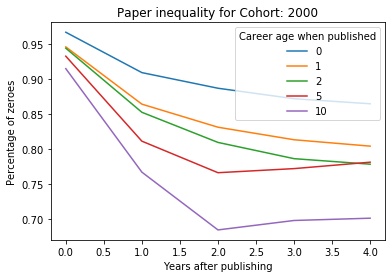

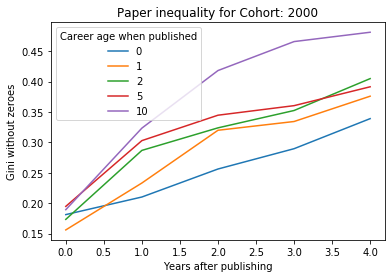

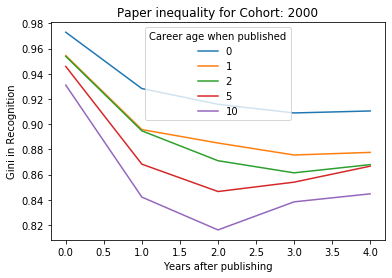

In [60]:
plot_ineq_papers_cohort(2000, 5, func=percentage_zeros)
plot_ineq_papers_cohort(2000, 5, func=gini_nonzero)
plot_ineq_papers_cohort(2000, 5, func=gini)

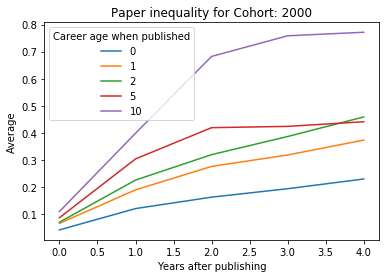

In [61]:
plot_ineq_papers_cohort(2000, 5, func=np.mean)

## Cohort Sizes

In [62]:
cohort_sizes = counts.groupby('start_year').agg({'author': 'nunique'})

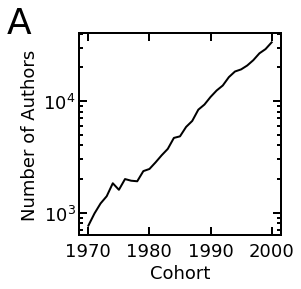

In [63]:
def plot_cohort_size_over_years():
    linewidth = 2
    fontsize = 18
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.plot(cohort_sizes.index, cohort_sizes.values, linewidth=linewidth, color='black')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_yscale('log')
    ax.set_xlabel('Cohort', fontsize=fontsize)
    ax.set_ylabel('Number of Authors', fontsize=fontsize)
    #ax.set_title('', fontsize=fontsize)
    ax.set_xticks([1970, 1980, 1990, 2000])
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    #ax.legend(fontsize=fontsize)
    plt.gcf().text(0., 0.9, 'A', fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    fig.savefig('./fig-7-notebook/cohort_size.pdf')
plot_cohort_size_over_years()

## Make plot

In [442]:
def plot_criteria_over_career_ages(data, criteria, criteria_name, title, letter, x_start=1, x_end=15, legend=True, name_ext=''):
    linewidth = 2
    fontsize = 18
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    color = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
    cohort = [1970, 1975, 1980, 1985, 1990, 1995, 2000]
    for i in range(0, 7):
        df = data[data['start_year'] == cohort[i]]
        df = df[(df['career_age'] >= x_start) & (df['career_age'] <= x_end)]
        ax.plot(df['career_age'], df[criteria], linewidth=linewidth, label=cohort[i], color=color[i])
    ax.set_xlim([0.25, 15.75])
    ax.set_ylim([-0.05, 1.05])
    if 'gini' in criteria:
        ax.set_ylim([-0.05, 1.05])
    if 'hhi' in criteria:
        ax.set_ylim([-0.004, 0.074])
    if 'pzero' in criteria:
        ax.set_ylim([-0.05, 1.05])
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_xlabel('Career Age', fontsize=fontsize)
    ax.set_ylabel(f'{criteria_name}', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xticks([1, 5, 10, 15])
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    if legend: ax.legend(fontsize=fontsize-6)
    plt.gcf().text(0., 0.9, letter, fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    fig.savefig(f'./fig-7-notebook/{criteria}{name_ext}.pdf')
    
    
def plot_heatmap(data, publish_years, crit):
    data_matrix = data.groupby('career_age').agg({f'ec_cit_{start}_{end}{crit}': 'mean' for start,end in publish_years})
    data_matrix[data_matrix < 0.0001] = None
    sns.heatmap(data_matrix.T[::-1], cmap="YlGnBu")

In [436]:
def agg_data_df(citations_window, func, func_name, remove_zero=False):
    cohort_counts = citations_window.groupby(['start_year', 'career_age']).agg({
    'cum_num_pub':func, 'cum_num_cit':func, 'win_num_pub':func, 'win_num_cit':func})
    # remove people not competing for attention
    if remove_zero:
        raise Exception("DONT REMOVE ZERO!")
        cohort_counts_pub_gt0 = citations_window[citations_window['win_num_pub']>0].groupby(
            ['start_year', 'career_age']).agg({'win_num_cit':func, 'win_num_pub':func})
        cohort_counts['win_num_cit'] = cohort_counts_pub_gt0['win_num_cit']
        cohort_counts['win_num_pub'] = cohort_counts_pub_gt0['win_num_pub']
    cohort_counts.reset_index(inplace=True)
    cohort_counts = cohort_counts.rename({
        'cum_num_pub':f'{func_name}_cum_num_pub', 
        'cum_num_cit':f'{func_name}_cum_num_cit',
        'win_num_pub':f'{func_name}_win_num_pub',
        'win_num_cit': f'{func_name}_win_num_cit'
    }, axis='columns')
    return cohort_counts

In [518]:
def plot_array_configs(data, configs, letters, x_ends, name_ext=''):
    for config, letter, x_end in zip(configs, letters, x_ends):
        legend = False
        if letter == 'A': legend = True
        plot_criteria_over_career_ages(data, *config, letter=letter, legend=legend, x_end=x_end, name_ext=name_ext)
        
def plot_array_configs2(data, configs, letters, name_ext=''):
    for config, letter in zip(configs, letters):
        legend = False
        if letter in ['A', 'E', 'I']: legend = True
        plot_criteria_over_cohorts(data, *config, letter=letter, legend=legend, name_ext=name_ext)

In [499]:
def get_num_auth(citations_window):
    return citations_window['author'].nunique()

def get_config(crit, crit_name, size=""):
    config1 = [(f'{crit}_cum_num_pub', f'{crit_name}', f'Productivity.{size}'), #Cumulative
               (f'{crit}_win_num_pub', f'{crit_name}', f'Productivity.{size}'), #Window 
                (f'{crit}_cum_num_cit', f'{crit_name}', f'Recognition.{size}'), #Cumulative
                (f'{crit}_win_num_cit', f'{crit_name}', f'Recognition.{size}')] #Window 
    return config1

def get_config2(crit, crit_name, size=""):
    config2 = [('cum_num_pub', f'{crit_name}', 'Productivity'), #Cumulative
               ('num_pub', f'{crit_name}', 'Productivity'), #Window 
                ('cum_num_cit', f'{crit_name}', 'Recognition'), #Cumulative
                ('num_cit', f'{crit_name}', 'Recognition')] #Window 
    return config2

letters1 = ['A', 'B', 'C', 'D']
letters2 = ['E', 'F', 'G', 'H']
letters3 = ['I', 'J', 'K', 'L']

letters11 = ['A', 'A', 'B', 'B']
letters12 = ['C', 'C', 'D', 'D']
letters21 = ['E', 'E', 'F', 'F']
letters22 = ['G', 'G', 'H', 'H']
letters31 = ['I', 'I', 'J', 'J']
letters32 = ['K', 'K', 'L', 'L']

x_ends = [15,13,15,13]
x_ends2 = [15,11,15,11]

In [281]:
def plot_early_late_work(author_early_work, years_list, name_ext=''):
    num_iter = len(years_list)
    crits = ['_cum', '']
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
    titles = ['Cum', 'Win']

    legend = True
    for i in range(0,num_iter*len(crits)):
        letter=letters[i]
        start,end = years_list[i%num_iter]
        crit = crits[i//num_iter]
        title = titles[i//num_iter]
        plot_criteria_over_career_ages(author_early_work, f'ec_cit_{start}_{end}{crit}', 'Gini Recognition', 
            title=f'{title}. (Papers of Age {start+1})', x_start=end,
            letter=letter, legend=legend, name_ext=name_ext)
        legend = False

In [282]:
def agg_data_early_late(citations_window, func, publish_years):
    aggregate = {f'ec_cit_{start}_{end}': func for start,end in publish_years}
    aggregate.update({f'ec_cit_{start}_{end}_cum': func for start,end in publish_years})

    author_early_work = citations_window[citations_window['num_pub']>0].groupby(['start_year', 'career_age']).agg(aggregate).reset_index()
    return author_early_work

###### Plot for latex

CPU times: user 20.7 s, sys: 740 ms, total: 21.5 s
Wall time: 2min 19s


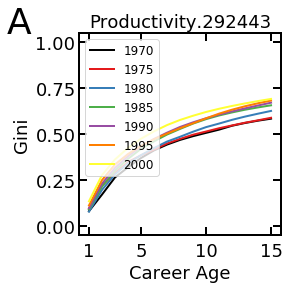

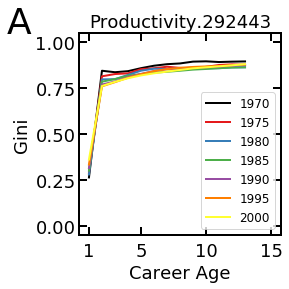

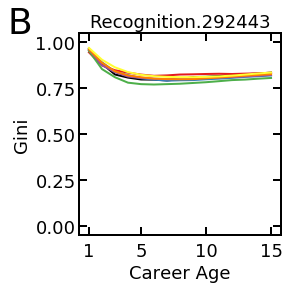

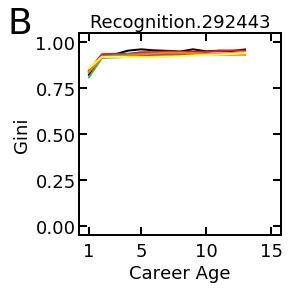

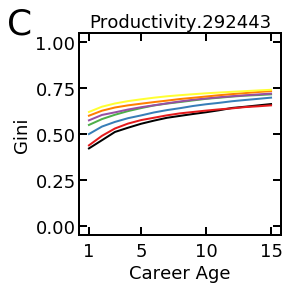

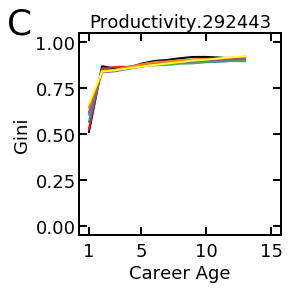

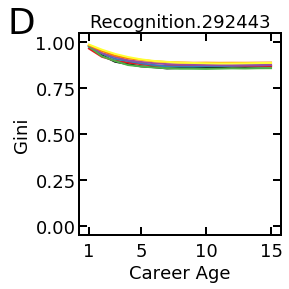

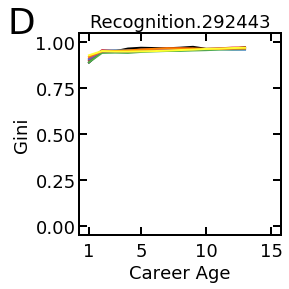

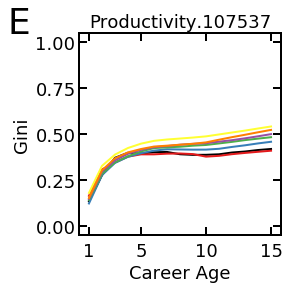

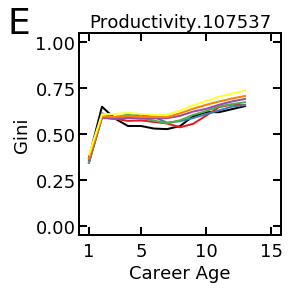

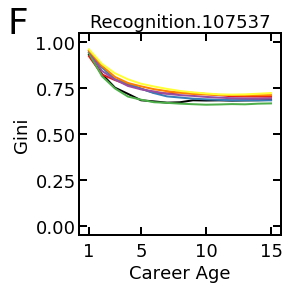

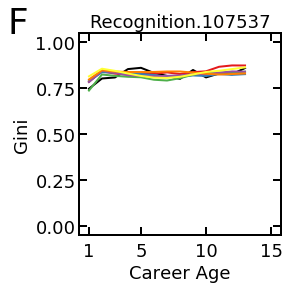

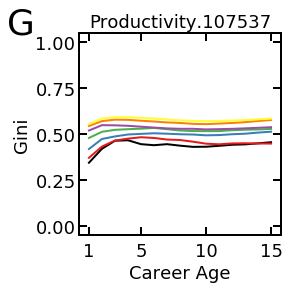

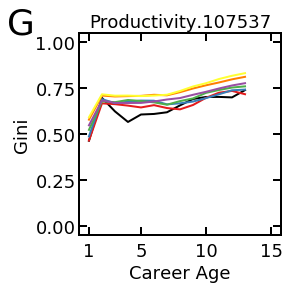

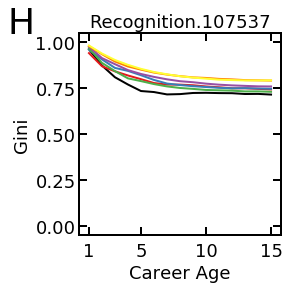

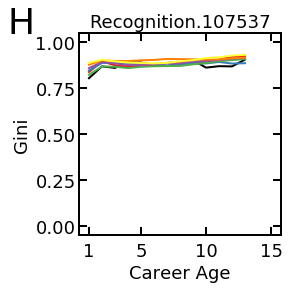

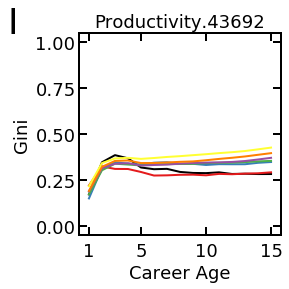

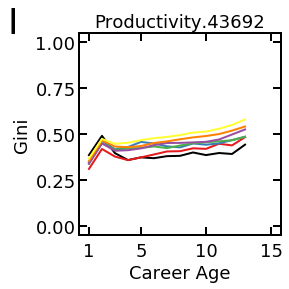

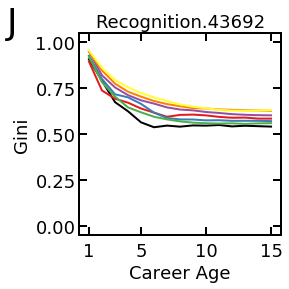

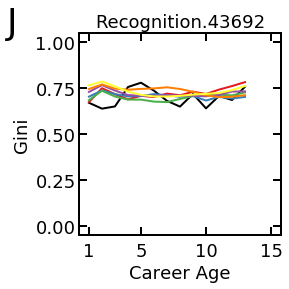

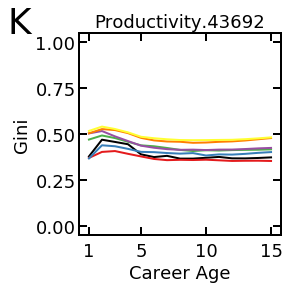

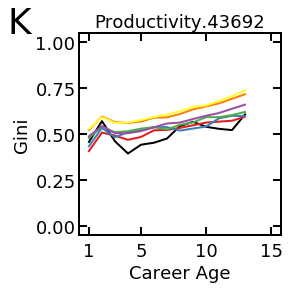

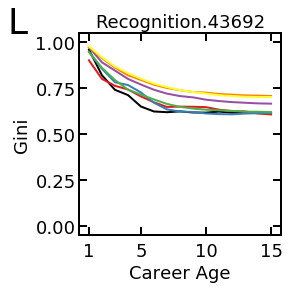

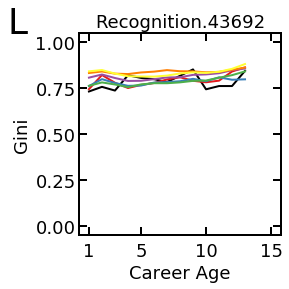

In [453]:
%%time
def plot_for_latex2(citations_window, citations_window_first, x_ends):
    # all authors
    cohort_counts_gini = agg_data_df(citations_window, gini, 'gini')
    plot_array_configs(cohort_counts_gini, get_config('gini', 'Gini'), letters1, x_ends)
    # zero removed
    cohort_counts_gini = agg_data_df(citations_window, gini, 'gini', remove_zero=True)
    plot_array_configs(cohort_counts_gini, get_config('gini', 'Gini'), letters2, x_ends, name_ext='_nozero')
    # zero percentage
    cohort_counts_pzero = agg_data_df(citations_window, percentage_zeros, 'pzero')
    plot_array_configs(cohort_counts_pzero, get_config('pzero', '%0'), letters3, x_ends)
    
def plot_for_latex(citations_window, citations_window_first, x_ends):
    # all authors
    cohort_counts_gini = agg_data_df(citations_window, gini, 'gini')
    plot_array_configs(cohort_counts_gini, get_config('gini', 'Gini', get_num_auth(citations_window)), letters11, x_ends)
    # first author
    cohort_counts_gini_first = agg_data_df(citations_window_first, gini, 'gini')
    plot_array_configs(cohort_counts_gini_first, get_config('gini', 'Gini', get_num_auth(citations_window_first)), letters12, x_ends, name_ext='_first')
    # dropouts removed 10y
    citations_window_stayed = citations_window[citations_window.dropped_after_10 == False]
    cohort_counts_stayed_gini = agg_data_df(citations_window_stayed, gini, 'gini')
    plot_array_configs(cohort_counts_stayed_gini, get_config('gini', 'Gini', get_num_auth(citations_window_stayed)), letters21, x_ends, name_ext='_stay10')
    # dropouts removed first auth 10y
    citations_window_stayed_first = citations_window_first[citations_window_first.dropped_after_10 == False]
    cohort_counts_stayed_gini_first = agg_data_df(citations_window_stayed_first, gini, 'gini')
    plot_array_configs(cohort_counts_stayed_gini_first, get_config('gini', 'Gini', get_num_auth(citations_window_stayed_first)), letters22, x_ends, name_ext='_stay10_first')
    # dropouts removed 5y
    citations_window_stayed_5 = citations_window[citations_window.dropped_after_5 == False]
    cohort_counts_stayed_gini_5 = agg_data_df(citations_window_stayed_5, gini, 'gini')
    plot_array_configs(cohort_counts_stayed_gini_5, get_config('gini', 'Gini', get_num_auth(citations_window_stayed_5)), letters31, x_ends, name_ext='_stay5')
    # dropouts removed first auth 5y
    citations_window_stayed_first_5 = citations_window_first[citations_window_first.dropped_after_5 == False]
    cohort_counts_stayed_gini_first_5 = agg_data_df(citations_window_stayed_first_5, gini, 'gini')
    plot_array_configs(cohort_counts_stayed_gini_first_5, get_config('gini', 'Gini', get_num_auth(citations_window_stayed_first_5)), letters32, x_ends, name_ext='_stay5_first')

plot_for_latex(citations_window, citations_window_first, x_ends)
# plot_for_latex(citations_window_5, citations_window_first_5, x_ends2)
# plot_for_latex2(citations_window, citations_window_first, x_ends)

## Ginis

#### First author

In [70]:
cohort_counts_gini_first = agg_data_df(citations_window_first, gini, 'gini')

In [414]:
citations_window_first_size = citations_window_first['author'].nunique()

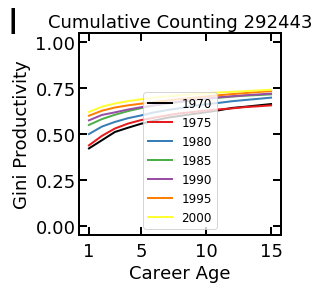

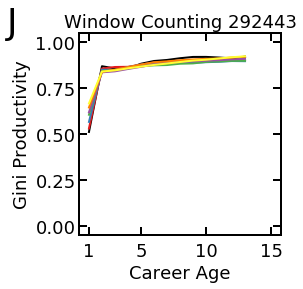

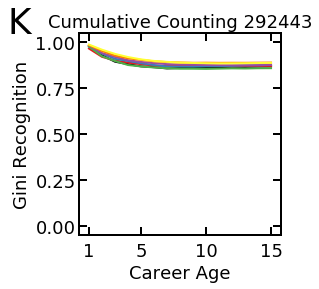

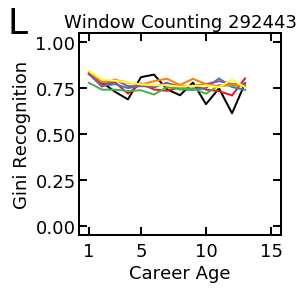

In [416]:
plot_array_configs(cohort_counts_gini_first, get_config('gini', 'Gini', citations_window_first_size), letters3, x_ends, name_ext='_first')

#### All authors

In [73]:
cohort_counts_gini = agg_data_df(citations_window, gini, 'gini')

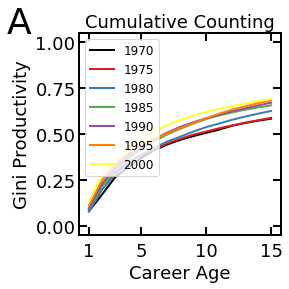

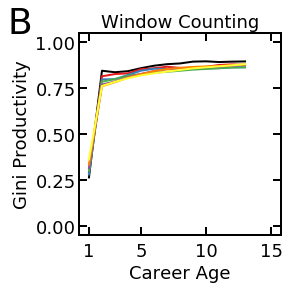

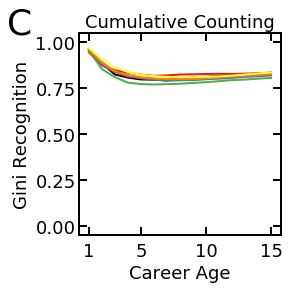

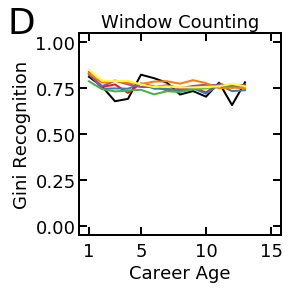

In [230]:
plot_array_configs(cohort_counts_gini, get_config('gini', 'Gini'), letters1, x_ends)

#### Non zero

In [76]:
cohort_counts_gini_nonzero = agg_data_df(citations_window, gini_nonzero, 'gini_nonzero')

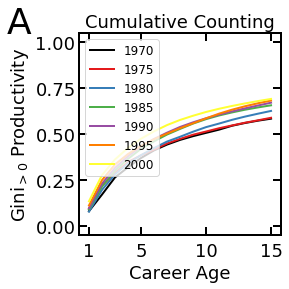

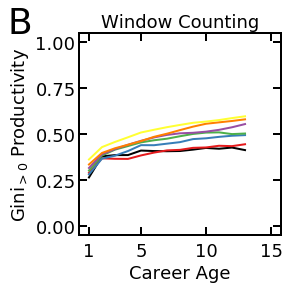

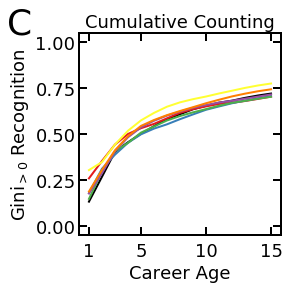

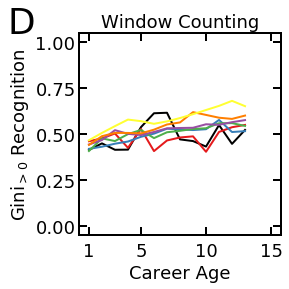

In [232]:
plot_array_configs(cohort_counts_gini_nonzero, get_config('gini_nonzero', 'Gini$_{>0}$'), letters1, x_ends)

#### Inequality of early vs later work

In [233]:
# publish_years = [[0,3], [3,6], [6,9], [0,1], [3,4], [6,7]]
# first_year = 0
# publish_years = [[i, i+1] for i in range(first_year,15)]
# author_gini_early_work = agg_data_early_late(citations_window, gini, publish_years)

In [ ]:
# plot_heatmap(author_gini_early_work, publish_years, '_cum')

In [ ]:
# plot_heatmap(author_gini_early_work, publish_years, '')

In [ ]:
# years_list = [[0,1], [3,4], [6,7]]
# plot_early_late_work(author_gini_early_work, years_list)

## HHI

In [234]:
cohort_counts_hhi = agg_data_df(citations_window, hhi, 'hhi')

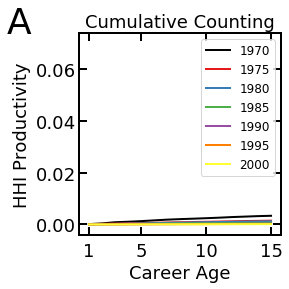

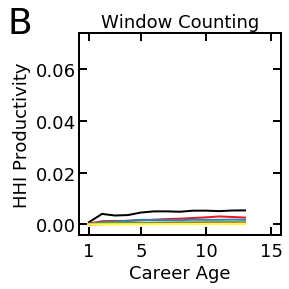

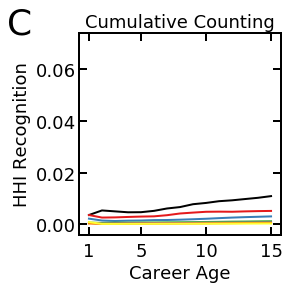

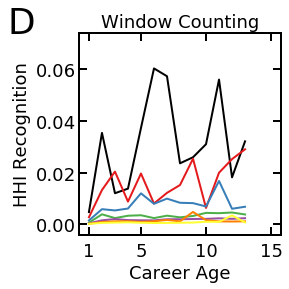

In [235]:
plot_array_configs(cohort_counts_hhi, get_config('hhi', 'HHI'), letters1, x_ends)

## Percentage zeros

In [236]:
cohort_counts_pzero = agg_data_df(citations_window, percentage_zeros, 'pzero')

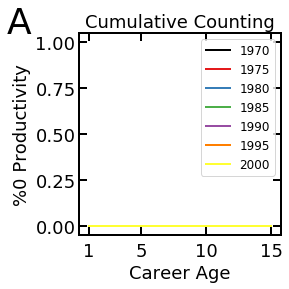

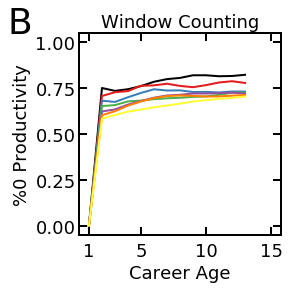

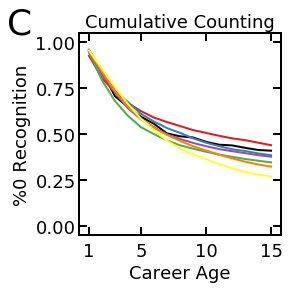

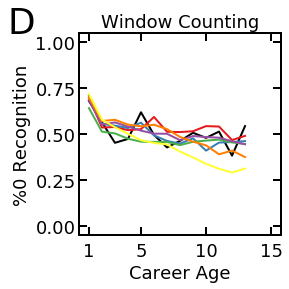

In [237]:
plot_array_configs(cohort_counts_pzero, get_config('pzero', '%0'), letters1, x_ends)

## Remove dropouts

In [238]:
citations_window_stayed = citations_window[citations_window.dropped_after_10 == False]

In [409]:
citations_window_stayed_size = citations_window_stayed['author'].nunique()

### Gini

In [ ]:
cohort_counts_stayed_gini = agg_data_df(citations_window_stayed, gini, 'gini')

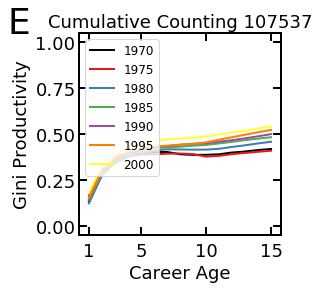

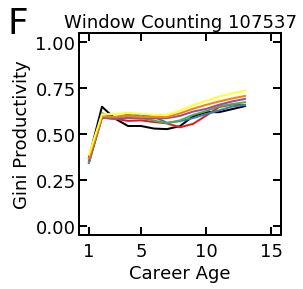

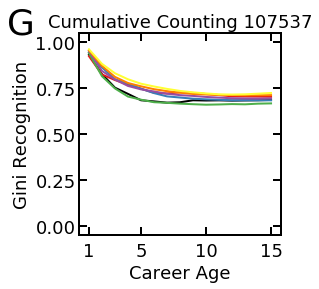

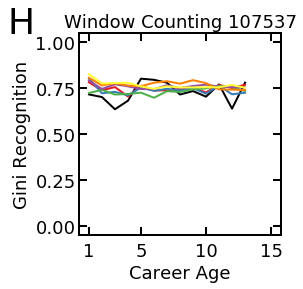

In [410]:
plot_array_configs(cohort_counts_stayed_gini, get_config('gini', 'Gini', citations_window_stayed_size), 
                   letters2, x_ends, name_ext='_stay')

### P zero

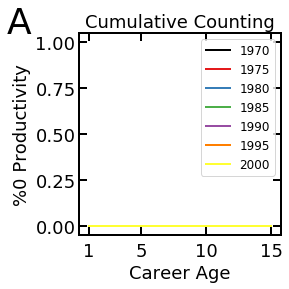

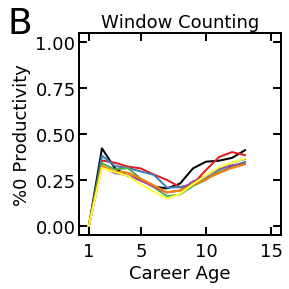

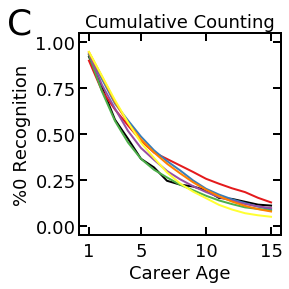

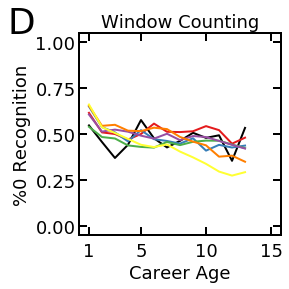

In [240]:
cohort_counts_stayed_pzero = agg_data_df(citations_window_stayed, percentage_zeros, 'pzero')
plot_array_configs(cohort_counts_stayed_pzero, get_config('pzero', '%0'), letters1, x_ends)

### Early vs late

In [ ]:
# publish_years = [[0,3], [3,6], [6,9], [0,1], [3,4], [6,7]]
publish_years = [[i, i+1] for i in range(1,15)]

author_gini_early_work_stayed = agg_data_early_late(citations_window_stayed, gini, publish_years)

In [ ]:
plot_heatmap(author_gini_early_work_stayed, publish_years, '')

In [ ]:
plot_heatmap(author_gini_early_work_stayed, publish_years, '_cum')

In [ ]:
author_gini_early_work_stayed.columns

In [ ]:
years_list = [[1,2], [3,4], [6,7]]
plot_early_late_work(author_gini_early_work_stayed, years_list, name_ext='_stay')

In [ ]:
stop here

## Distributions

### Cohort Years
Cumulative numbers needed.

In [ ]:
start_year = 2000
career_age = 15
data = counts[(counts['start_year'] == start_year) & (counts['career_age'] == career_age)]['cum_num_pub']
data = data[data > 0]
#np.median(data)
#np.round(np.mean(data))

In [ ]:
# pdf='cum_num_pub_2000.pdf'
cars.fit_univariate(data, discrete=True, xmin=1, xlabel='p', title='2000', bins=24, bootstrap=None, col=1, marker='o', markersize=12, linewidth=2, fontsize=24, unbinned_data=True, pdf=None, png=None)

In [ ]:
#guys from 2000 cohort with more than 300 papers
counts[(counts['start_year'] == 2000) & (counts['career_age'] == 15) & (counts['cum_num_pub'] > 300)][['author', 'cum_num_pub']]

### Years

In [ ]:
# publications produced between 1971 and 2014
#p = list(counts[counts['year'].between(1971, 2014)][['author', 'num_pub']].groupby('author').sum().reset_index(drop=True)['num_pub'])
# publications by all authors from cohorts 1971 to 2000 produced in their first 15 years
p = list(counts[(counts['start_year'].between(1971, 2000)) & (counts['career_age'].between(1, 15))][['author', 'num_pub']].groupby('author').sum().reset_index(drop=True)['num_pub'])
p = [int(x) for x in p if x>0]

In [ ]:
# citations received between 1971 and 2014
#c = list(counts[counts['year'].between(1971, 2014)][['author', 'num_cit']].groupby('author').sum().reset_index(drop=True)['num_cit'])
# citations received by all authors from cohorts 1971 to 2000 in their first 15 years
c = list(counts[(counts['start_year'].between(1971, 2000)) & (counts['career_age'].between(1, 15))][['author', 'num_cit']].groupby('author').sum().reset_index(drop=True)['num_cit'])
c = [int(x) for x in c if x>0]

In [ ]:
import compsoc as cs

In [ ]:
parameters_p, test_statistics_p = cs.fit_power_law(l=p, discrete=True, xmin=1, fit=None, sims=None, bootstrap=None, data_original=False, markersize=9, linewidth=2, fontsize=18, marker=0, color=1, xlabel='p', title='', legend=False, letter='', Pdf=None, png=None)

In [ ]:
parameters_c, test_statistics_c = cs.fit_power_law(l=c, discrete=True, xmin=1, fit=None, sims=None, bootstrap=None, data_original=False, markersize=9, linewidth=2, fontsize=18, marker=0, color=2, xlabel='c', title='', legend=False, letter='', Pdf=None, png=None)

In [ ]:
a_bin_p = cs.bin_pdf(cs.pdf(p))
a_bin_c = cs.bin_pdf(cs.pdf(c))

In [ ]:
import powerlaw as pl

In [ ]:
f_p = pl.Fit(p, discrete=True, xmin=1)
f_c = pl.Fit(c, discrete=True, xmin=1)

In [ ]:
space_xmin_p = np.logspace(np.log10(f_p.xmin), np.log10(max(f_p.data_original)), 100)
space_xmin_c = np.logspace(np.log10(f_c.xmin), np.log10(max(f_c.data_original)), 100)
scale_p = f_p.n_tail/len(f_p.data_original)
scale_c = f_c.n_tail/len(f_c.data_original)

In [ ]:
fontsize = 18
linewidth = 2
markersize = 9
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']
fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot(111)
ax1.plot(a_bin_p[:, 0], a_bin_p[:, 3], marker='o', color='#e41a1c', ls='', markersize=markersize, label='$x=p$')
ax1.plot(a_bin_c[:, 0], a_bin_c[:, 3], marker='o', color='#377eb8', ls='', markersize=markersize, label='$x=c$')
ax1.plot(space_xmin_p, scale_p*f_p.truncated_power_law.pdf(space_xmin_p), color='k', ls='-', linewidth=linewidth)
ax1.plot(space_xmin_c, scale_c*f_c.lognormal.pdf(space_xmin_c), color='k', ls='--', linewidth=linewidth)
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$x$', fontsize=fontsize)
ax1.set_ylabel('$p(x)$', fontsize=fontsize)
ax1.set_xticks([1, 10, 100, 1000, 10000])
ax1.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
ax1.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
ax1.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
ax1.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
ax1.spines['left'].set_linewidth(linewidth)
ax1.spines['right'].set_linewidth(linewidth)
ax1.spines['bottom'].set_linewidth(linewidth)
ax1.spines['top'].set_linewidth(linewidth)
ax1.legend(fontsize=fontsize-6)
plt.gcf().text(0., 0.9, 'B', fontsize=fontsize*2)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
fig.savefig('./fig-7-notebook/distributions.pdf')
plt.show()

In [ ]:
year = 2014
p = counts[counts['year'] == year]['cum_num_pub']
p = p[p > 0]
#np.median(p)
#np.round(np.mean(p))

In [ ]:
# pdf='years_cum_num_pub_2014.pdf'
cars.fit_univariate(p, discrete=True, xmin=1, xlabel='p', title=None, bins=24, bootstrap=None, col=1, marker='o', markersize=12, linewidth=2, fontsize=18, unbinned_data=True, pdf='years_cum_num_pub_2014.pdf', png='years_cum_num_pub_2014.png')

In [ ]:
pubids = authorPublicationData.pub_id.tolist()

In [ ]:
df_citations = pd.read_csv('data/paper_venue_citations.csv', sep='\t')

In [ ]:
df_citations = df_citations[df_citations.year.between(1970, 2014)]
df_citations = df_citations[df_citations.paper2.isin(pubids)]

In [ ]:
c = df_citations.groupby(['venue2']).size()

In [ ]:
### pdf='years_cum_num_cit_2014.pdf'
cars.fit_univariate(c, discrete=True, xmin=(1, 10), xlabel='c', title=None, bins=24, bootstrap=None, col=2, marker='o', markersize=12, linewidth=2, fontsize=18, unbinned_data=True, pdf='bradford_2014.pdf', png='bradford_2014.png')

## Matthew Effect

In [ ]:
# prepare output tables
micro_stats = pd.DataFrame(columns=['t', 'dt', 'author', 'eta'])
macro_stats = pd.DataFrame(columns=['t', 'dt', 'n', 'D', 'beta', 'beta_std', 'r2', 'reduced_chi'])
# settings
dt = 5
unit = 'num_cit' # CHANGE COLOR (1) AND LETTER (5)
fit = 'odr'
for t in range(1970+dt, 2015-dt+2): # range(1975, 2012) for dt=5
    # get vectors
    t0 = counts[counts['year'].between(t-dt, t-1)][['author', unit]].groupby('author').sum()
    t1 = counts[counts['year'].between(t, t+dt-1)][['author', unit]].groupby('author').sum()
    #t1 = counts[counts['year'].between(t, t)][['author', unit]].groupby('author').sum()
    t0 = t0[t0[unit] > 0]
    t1 = t1[t1[unit] > 0]
    # merge vectors into dataframe
    ca = pd.merge(left=t0, right=t1, left_index=True, right_index=True)
    ca.columns = ['t0', 't1']
    # fit
    df_stats, df_bootstrap = cars.fit_bivariate(ca['t0'], ca['t1'], fit=fit, reduction='bin', color=2, xlabel='c_{%.0f-%.0f}' %(t-dt, t-1), ylabel='c_{%.0f-%.0f}' %(t, t+dt-1), title='', pdf='matthew/macro_c_'+fit+'Bin_t'+str(t)+'_dt'+str(dt)+'.pdf')
    # extend micro stats (fitness)
    ca['t'] = t
    ca['dt'] = dt
    ca['author'] = ca.index
    t1_exp = df_stats['D'][0]*ca['t0']**df_stats['beta'][0]
    ca['eta'] = ca['t1']/t1_exp
    ca = ca[['t', 'dt', 'author', 'eta']]
    # extend macro stats
    df_stats['t'] = t
    df_stats['dt'] = dt
    df_stats = df_stats[['t', 'dt', 'n', 'D', 'beta', 'beta_std', 'r2', 'reduced_chi']]
    # append stats
    micro_stats = pd.concat([micro_stats, ca], axis=0, ignore_index=True)
    macro_stats = pd.concat([macro_stats, df_stats], axis=0, ignore_index=True)
# write output tables
micro_stats.to_csv('matthew/micro_c_'+fit+'Bin_dt'+str(dt)+'.txt', sep='\t', index=False)
macro_stats.to_csv('matthew/macro_c_'+fit+'Bin_dt'+str(dt)+'.txt', sep='\t', index=False)

### Cumulative Advantage

In [ ]:
macro_p_olsBin_dt5 = pd.read_csv('matthew/macro_p_olsBin_dt5.txt', sep='\t')
macro_c_olsBin_dt5 = pd.read_csv('matthew/macro_c_olsBin_dt5.txt', sep='\t')

In [ ]:
macro_p_odrBin_dt5 = pd.read_csv('matthew/macro_p_odrBin_dt5.txt', sep='\t')
macro_c_odrBin_dt5 = pd.read_csv('matthew/macro_c_odrBin_dt5.txt', sep='\t')

In [ ]:
plt.fill_between(macro_p_olsBin_dt5['t'], macro_p_olsBin_dt5['beta']-macro_p_olsBin_dt5['beta_std'], macro_p_olsBin_dt5['beta']+macro_p_olsBin_dt5['beta_std'], color=color_pale[1], linewidth=0)
plt.fill_between(macro_c_olsBin_dt5['t'], macro_c_olsBin_dt5['beta']-macro_c_olsBin_dt5['beta_std'], macro_c_olsBin_dt5['beta']+macro_p_olsBin_dt5['beta_std'], color=color_pale[2], linewidth=0)
plt.plot(macro_p_olsBin_dt5['t'], macro_p_olsBin_dt5['beta'], color=color_full[1], label='Productivity')
plt.plot(macro_c_olsBin_dt5['t'], macro_c_olsBin_dt5['beta'], color=color_full[2], label='Recognition')
plt.title('Ordinary Least Squares')
plt.xlabel('Year')
plt.ylabel('Cumulative Advantage')
plt.legend()

In [ ]:
plt.fill_between(macro_p_odrBin_dt5['t'], macro_p_odrBin_dt5['beta']-macro_p_odrBin_dt5['beta_std'], macro_p_odrBin_dt5['beta']+macro_p_odrBin_dt5['beta_std'], color=color_pale[1], linewidth=0)
plt.fill_between(macro_c_odrBin_dt5['t'], macro_c_odrBin_dt5['beta']-macro_c_odrBin_dt5['beta_std'], macro_c_odrBin_dt5['beta']+macro_p_odrBin_dt5['beta_std'], color=color_pale[2], linewidth=0)
plt.plot(macro_p_odrBin_dt5['t'], macro_p_odrBin_dt5['beta'], color=color_full[1], label='Productivity')
plt.plot(macro_c_odrBin_dt5['t'], macro_c_odrBin_dt5['beta'], color=color_full[2], label='Recognition')
plt.title('Orthogonal Distance Regression')
plt.xlabel('Year')
plt.ylabel('Cumulative Advantage')
plt.legend()

### Fitness

In [ ]:
micro_p_olsBin_dt5 = pd.read_csv('matthew/micro_p_olsBin_dt5.txt', sep='\t')
micro_c_olsBin_dt5 = pd.read_csv('matthew/micro_c_olsBin_dt5.txt', sep='\t')

In [ ]:
micro_p_odrBin_dt5 = pd.read_csv('matthew/micro_p_odrBin_dt5.txt', sep='\t')
micro_c_odrBin_dt5 = pd.read_csv('matthew/micro_c_odrBin_dt5.txt', sep='\t')

Users with long careers:

In [ ]:
micro_p_olsBin_dt5.groupby('author').count()

In [ ]:
#author = 'a min tjoa'
#author = 'a-nasser ansari'
#author = 'a-xing zhu'
author = 'a. a. (louis) beex'
#author = 'a. a. agboola'
#author = 'a. a. ball'
#author = 'a. a. el-bary'
#author = 'ülkü gürler'
#author = 'ülle kotta'
#author = 'ülo nurges'
#author = 'ümit aygölü'
#author = 'ümit bilge'
#author = 'ümit güz'
#author = 'ümit v. çatalyürek'
#author = 'ümit y. ogras'
#author = 'ümit özgüner'
#author = 'ünal göktas'
#author = 'ünal ufuktepe'
p = micro_p_olsBin_dt5[micro_p_olsBin_dt5['author'] == author]
c = micro_c_olsBin_dt5[micro_c_olsBin_dt5['author'] == author]
plt.plot(p['t'], p['eta'], label='Productivity')
plt.plot(c['t'], c['eta'], label='Recognition')
plt.xlabel('Year')
plt.ylabel('Fitness')
plt.legend()

Lognormal fitness distributions:

In [ ]:
etaMean_p_olsBin_dt5 = micro_p_olsBin_dt5.groupby('author').mean().sort_values('eta', ascending=False)['eta']
etaMean_c_olsBin_dt5 = micro_c_olsBin_dt5.groupby('author').mean().sort_values('eta', ascending=False)['eta']

In [ ]:
print('mean:', np.mean(np.log10(etaMean_p_olsBin_dt5)))
print('std:', np.std(np.log10(etaMean_p_olsBin_dt5)))
plt.hist(np.log10(etaMean_p_olsBin_dt5))

In [ ]:
print('mean:', np.mean(np.log10(etaMean_c_olsBin_dt5)))
print('std:', np.std(np.log10(etaMean_c_olsBin_dt5)))
plt.hist(np.log10(etaMean_c_olsBin_dt5))

Correlation of productivity and recognition fitness:

In [ ]:
etaMean_olsBin_dt5 = pd.concat([etaMean_p_olsBin_dt5, etaMean_c_olsBin_dt5], axis=1)
etaMean_olsBin_dt5.columns = ['p', 'c']

In [ ]:
etaMean_olsBin_dt5.dropna(inplace=True)

In [ ]:
print('corrcoef:', np.corrcoef(etaMean_olsBin_dt5['p'], etaMean_olsBin_dt5['c'])[0, 1])
plt.scatter(etaMean_olsBin_dt5['p'], etaMean_olsBin_dt5['c'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean Productivity Fitness')
plt.ylabel('Mean Recognition Fitness')

## Variance of Fitness for Cohorts

In [ ]:
counts[counts['author'] == 'a. breton']

In [ ]:
micro_p_olsBin_dt5[micro_p_olsBin_dt5['author'] == 'a. breton']

In [ ]:
counts_fitness_p = pd.merge(left=counts, right=micro_p_olsBin_dt5, left_on=['author', 'year'], right_on=['author', 't'])
counts_fitness_c = pd.merge(left=counts, right=micro_c_olsBin_dt5, left_on=['author', 'year'], right_on=['author', 't'])

In [ ]:
counts_fitness_p.head()

In [ ]:
counts_fitness_c.head()

Note: eta for 1975 is based on productivity in 1975-1979.

In [ ]:
counts_fitness_p_mean = counts_fitness_p.groupby(['start_year', 'career_age']).mean().reset_index()
for start_year in [1975, 1980, 1985, 1990, 1995, 2000]: # range(1975, 2012)
    df = counts_fitness_p_mean[counts_fitness_p_mean['start_year'] == start_year]
    plt.plot(df['career_age'], df['eta'], label=start_year)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Productivity Fitness')
    plt.legend()

In [ ]:
counts_fitness_c_mean = counts_fitness_c.groupby(['start_year', 'career_age']).mean().reset_index()
for start_year in [1975, 1980, 1985, 1990, 1995, 2000]: # range(1975, 2012)
    df = counts_fitness_c_mean[counts_fitness_c_mean['start_year'] == start_year]
    plt.plot(df['career_age'], df['eta'], label=start_year)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Recognition Fitness')
    plt.legend()

On average, scholars have high fitness at the beginning of their career. To which extent is the mean influenced by scholars with long careers? In other wordw, is high fitness in early years a predictor of career duration?

In [ ]:
AB HIER BAUSTELLE

In [ ]:
career_duration = [6, 10]
counts_fitness_p_mean = counts_fitness_p[counts_fitness_p['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
max(counts_fitness_p_mean['career_age'])

In [ ]:
for career_duration in [[1, 5], [6, 10], [11, 15], [15, 20], [21, 25]]:
    counts_fitness_p_mean = counts_fitness_p[counts_fitness_p['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
    plt.plot(counts_fitness_p_mean['career_age'], counts_fitness_p_mean['eta'], label=career_duration)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Productivity Fitness')
    plt.legend()

In [ ]:
career_duration = [6, 10]
counts_fitness_c_mean = counts_fitness_c[counts_fitness_c['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
max(counts_fitness_c_mean['career_age'])

In [ ]:
counts_fitness_c

In [ ]:
for career_duration in [[1, 5], [6, 10], [11, 15], [15, 20], [21, 25]]:
    counts_fitness_c_mean = counts_fitness_c[counts_fitness_c['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
    plt.plot(counts_fitness_c_mean['career_age'], counts_fitness_c_mean['eta'], label=career_duration)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Recognition Fitness')
    plt.legend()